# Classification of Alzheimer's Disease
## CS209A Final Project
## Group 6: Xiangru Shu, Shiyun Qiu, Yuyue Wang, Yiqi Xie

In [1]:
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)


## Merge

We analyzed the data collected under both ADNI1 and ADNI2 protocol and found that the missing rate was extremely high for many important predictors in ADNI1. Even though we have slightly more observations (819 patients) under ADNI1 protocol, ADNI2 data for patients (789 patients) is more complete.  Thus, we decided to base our model only on the data collected under ADNI2 protocol. 

Biomarkers may exist before clinical symptoms arise, and they could help us predict the onslaught of Alzheimer’s disease. To include more information about biomarkers, we merged the data in ADNIMERGE with UPenn CSF biomarkers. This file contains three biomarkers, `CSF_ABETA`, `CSF_TAU` and `CSF_PTAU`.

In [2]:
adnimerge = pd.read_csv("data/ADNIMERGE.csv")
adnimerge = adnimerge[(adnimerge.COLPROT=="ADNI2")&(adnimerge.ORIGPROT=="ADNI2")]

# merge a file to get more information on biomarkers
cols_effective_biomarker = ['RID', 'ABETA', 'TAU', 'PTAU']
CSF_biomarker = pd.read_csv("data/UPENN_CSF Biomarkers_baseline_May15.2014.csv")
CSF_biomarker = CSF_biomarker[cols_effective_biomarker]
CSF_biomarker = CSF_biomarker.rename(columns=lambda s:'CSF_'+s)

adnimerge = adnimerge.merge(CSF_biomarker, how='left', left_on='RID', right_on='CSF_RID')

print(adnimerge.shape)
adnimerge.head()

(4717, 98)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,CSF_RID,CSF_ABETA,CSF_TAU,CSF_PTAU
0,5282,082_S_5282,bl,82,ADNI2,ADNI2,09/09/13,SMC,66.9,Male,17,Not Hisp/Latino,White,Married,1.0,1.13549,NaN,1.326790,0.0,10.0,15.0,29.0,42.0,5.0,2.0,20.0000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625,1.33333,1.14286,1.2,1.00000,1.00000,1.25641,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),NaN,7851.0,NaN,NaN,NaN,NaN,1498720.0,CN,09/09/13,0.0,10.0,15.0,29,42.0,5.0,2.0,20.0,0.0,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),NaN,7851.0,NaN,NaN,NaN,NaN,1498720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625,1.33333,1.14286,1.2,1.00000,1.00000,1.25641,1.13549,NaN,1.326790,0.000000,0.00000,0,0,20:00.0,NaN,NaN,NaN,NaN
1,5280,100_S_5280,m24,100,ADNI2,ADNI2,29/09/15,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,NaN,NaN,0.982566,0.0,2.0,3.0,30.0,38.0,6.0,5.0,50.0000,0.0,27.0,1.625,1.11111,1.14286,1.2,1.66667,1.50,1.35897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,17/09/13,0.0,3.0,5.0,30,42.0,7.0,2.0,20.0,0.0,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,28.0,1.875,1.00000,1.0,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,1.25195,NaN,0.983143,2.031490,24.32790,24,24,20:00.0,NaN,NaN,NaN,NaN
2,5280,100_S_5280,m06,100,ADNI2,ADNI2,06/03/14,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,NaN,NaN,NaN,0.0,3.0,4.0,29.0,54.0,6.0,2.0,16.6667,0.0,24.0,1.875,1.00000,1.00000,1.2,1.40000,1.25,1.28947,1.750,1.11111,1.33333,1.2,NaN,1.25000,1.40000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,17/09/13,0.0,3.0,5.0,30,42.0,7.0,2.0,20.0,0.0,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,28.0,1.875,1.00000,1.0,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,1.25195,NaN,0.983143,0.465435,5.57377,6,6,20:00.0,NaN,NaN,NaN,NaN
3,5280,100_S_5280,bl,100,ADNI2,ADNI2,17/09/13,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,1.25195,NaN,0.983143,0.0,3.0,5.0,30.0,42.0,7.0,2.0,20.0000,0.0,28.0,1.875,1.00000,1.00000,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,CN,17/09/13,0.0,3.0,5.0,30,42.0,7.0,2.0,20.0,0.0,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,28.0,1.875,1.00000,1.0,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,1.25195,NaN,0.983143,0.000000,0.00000,0,0,20:00.0,NaN,NaN,NaN,NaN
4,5279,082_S_5279,bl,82,ADNI2,ADNI2,23/10/13,SMC,68.5,Male,20,Not Hisp/Latino,White,Married,0.0,1.50629,NaN,0.985156,0.0,4.0,7.0,30.0,61.0,6.0,3.0,20.0000,0.0,27.0,1.250,1.44444,1.00000,1.0,1.16667,1.75,1.25641,1.875,1.22222,1.28571,1.0,1.33333,1.33333,1.37838,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),21327.0,7654.0,1081140.0,4065.0,17964.0,18611.0,1508210.0,CN,23/10/13,0.0,4.0,7.0,30,61.0,6.0,3.0,20.0,0.0,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1)

In [3]:
# Number of patients in each category
num_all = np.sum(adnimerge['VISCODE']=='bl')
num_CN = np.sum((adnimerge['DX_bl']=='CN')&(adnimerge['VISCODE']=='bl'))
num_AD = np.sum((adnimerge['DX_bl']=='AD')&(adnimerge['VISCODE']=='bl'))
num_other = num_all - num_CN - num_AD

print("Number of patients in each category")
print("-----------------------------------")
print('total:', num_all)
print('CN    patients:', num_CN)
print('AD    patients:', num_AD)
print('other patients:', num_other)

Number of patients in each category
-----------------------------------
total: 789
CN    patients: 188
AD    patients: 150
other patients: 451


## Pick Predictors

Deleted Columns & Reasons:
1. Unnecessary information due to data selection: `COLPROT`, `ORIGPROT`
2. Unrelated information: `PTID`, `SITE`,`EXAMDATE`,`FLDSTRENG`, `FSVERSION`
3. Information explained by or can be retrieved by other predictors: `VISCODE`, all `xxx_bl` predictors except `Month_bl`
4. Complete data missing due to group selection: `PIB`

In [4]:
cols_of_interests = ['RID', 'DX_bl', 
                     'AGE', 'PTGENDER', 'PTEDUCAT', 
                     'PTETHCAT', 'PTRACCAT', 'PTMARRY', 
                     'APOE4', 'CSF_ABETA', 'CSF_TAU', 'CSF_PTAU', 
                     'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 
                     'RAVLT_immediate', 'RAVLT_learning', 
                     'RAVLT_forgetting', 'RAVLT_perc_forgetting', 
                     'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 
                     'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 
                     'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 
                     'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 
                     'EcogSPDivatt', 'EcogSPTotal', 'FAQ', 
                     'Ventricles', 'Hippocampus', 'WholeBrain', 
                     'Entorhinal', 'Fusiform', 'MidTemp', 
                     'ICV', 'DX', 'Month_bl', 'Month']

adnimerge_clean = adnimerge[cols_of_interests].copy()
print(adnimerge_clean.shape)
adnimerge_clean.head()

(4717, 48)


,RID,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,Month_bl,Month
0,5282,SMC,66.9,Male,17,Not Hisp/Latino,White,Married,1.0,NaN,NaN,NaN,1.13549,1.326790,0.0,10.0,15.0,29.0,42.0,5.0,2.0,20.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625,1.33333,1.14286,1.2,1.00000,1.00000,1.25641,0.0,NaN,7851.0,NaN,NaN,NaN,NaN,1498720.0,CN,0.00000,0
1,5280,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,NaN,NaN,NaN,NaN,0.982566,0.0,2.0,3.0,30.0,38.0,6.0,5.0,50.0000,27.0,1.625,1.11111,1.14286,1.2,1.66667,1.50,1.35897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,24.32790,24
2,5280,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,NaN,NaN,NaN,NaN,NaN,0.0,3.0,4.0,29.0,54.0,6.0,2.0,16.6667,24.0,1.875,1.00000,1.00000,1.2,1.40000,1.25,1.28947,1.750,1.11111,1.33333,1.2,NaN,1.25000,1.40000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,5.57377,6
3,5280,SMC,67.5,Male,16,Not Hisp/Latino,Black,Never married,0.0,NaN,NaN,NaN,1.25195,0.983143,0.0,3.0,5.0,30.0,42.0,7.0,2.0,20.0000,28.0,1.875,1.00000,1.00000,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,0.0,33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,CN,0.00000,0
4,5279,SMC,68.5,Male,20,Not Hisp/Latino,White,Married,0.0,NaN,NaN,NaN,1.50629,0.985156,0.0,4.0,7.0,30.0,61.0,6.0,3.0,20.0000,27.0,1.250,1.44444,1.00000,1.0,1.16667,1.75,1.25641,1.875,1.22222,1.28571,1.0,1.33333,1.33333,1.37838,0.0,21327.0,7654.0,1081140.0,4065.0,17964.0,18611.0,1508210.0,CN,0.00000,0


## Encoding

We transformed all remaining categorical variables into numerical values. For baseline diagnosis DX_bl, we mapped cognitive normal `CN` to 0, cognitive impairment (`LMCI`, `EMCI`, `SMC`) to 1 and Alzheimer's Disease `AD` to 2. Our task became a multiclass classification problem. For gender `PTGENDER`, we labeled Female as 0, and Male as 1. We used one-hot encoding for all other categorical variables. For `PTETHCAT` and `PTMARRY`, we found there are a few `Unknown`'s inside the data. Since the number of `Unknown`'s is very small, we simply dropped the rows with missing values in these columns to avoid adding another variable. 

In [5]:
# categorical variables
adnimerge_clean['DX_bl'] = adnimerge_clean['DX_bl'].map({'CN':0,'AD':2,'EMCI':1,'LMCI':1,'SMC':1})
adnimerge_clean['PTGENDER'] = adnimerge_clean['PTGENDER'].map({'Female':0,'Male':1})
adnimerge_clean = pd.get_dummies(adnimerge_clean, columns=['PTRACCAT'], drop_first=True)
# delete a small number of rows that missing value
adnimerge_clean = adnimerge_clean[adnimerge_clean.PTETHCAT!='Unknown']
adnimerge_clean = pd.get_dummies(adnimerge_clean, columns=['PTETHCAT'], drop_first=True)
adnimerge_clean = adnimerge_clean[adnimerge_clean.PTMARRY!='Unknown']
adnimerge_clean = pd.get_dummies(adnimerge_clean, columns=['PTMARRY'], drop_first=True)
# remove space in column names
col_names_replaced = [col.replace(' ', '_') for col in adnimerge_clean.columns]
adnimerge_clean.rename(columns=dict(zip(adnimerge_clean.columns, col_names_replaced)), inplace=True)

print(adnimerge_clean.shape)
adnimerge_clean.head()

(4681, 55)


,RID,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,Month_bl,Month,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed
0,5282,1,66.9,1,17,1.0,NaN,NaN,NaN,1.13549,1.326790,0.0,10.0,15.0,29.0,42.0,5.0,2.0,20.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625,1.33333,1.14286,1.2,1.00000,1.00000,1.25641,0.0,NaN,7851.0,NaN,NaN,NaN,NaN,1498720.0,CN,0.00000,0,0,0,0,0,0,1,1,1,0,0
1,5280,1,67.5,1,16,0.0,NaN,NaN,NaN,NaN,0.982566,0.0,2.0,3.0,30.0,38.0,6.0,5.0,50.0000,27.0,1.625,1.11111,1.14286,1.2,1.66667,1.50,1.35897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,24.32790,24,0,1,0,0,0,0,1,0,1,0
2,5280,1,67.5,1,16,0.0,NaN,NaN,NaN,NaN,NaN,0.0,3.0,4.0,29.0,54.0,6.0,2.0,16.6667,24.0,1.875,1.00000,1.00000,1.2,1.40000,1.25,1.28947,1.750,1.11111,1.33333,1.2,NaN,1.25000,1.40000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN,5.57377,6,0,1,0,0,0,0,1,0,1,0
3,5280,1,67.5,1,16,0.0,NaN,NaN,NaN,1.25195,0.983143,0.0,3.0,5.0,30.0,42.0,7.0,2.0,20.0000,28.0,1.875,1.00000,1.00000,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.0,1.25000,1.00000,1.25000,0.0,33185.0,8297.0,1165500.0,4946.0,20147.0,21194.0,1656460.0,CN,0.00000,0,0,1,0,0,0,0,1,0,1,0
4,5279,1,68.5,1,20,0.0,NaN,NaN,NaN,1.50629,0.985156,0.0,4.0,7.0,30.0,61.0,6.0,3.0,20.0000,27.0,1.250,1.44444,1.00000,1.0,1.16667,1.75,1.25641,1.875,1.22222,1.28571,1.0,1.33333,1.33333,1.37838,0.0,21327.0,7654.0,1081140.0,4065.0,17964.0,18611.0,1508210.0,CN,0.00000,0,0,0,0,0,0,1,1,1,0,0


## Trend Summary

To deal with the longitudinal component of the data, we decided to add an additional variable for each continuous predictor. These variables are the slopes of observations for all visits of each patient. The slopes indicated the progress or changes of each predictor as time passed by. For example, the negative slope of `Hippocampus` for `AD` patients indicates that the volumne of `Hippocampus` is decreasing over time. If there is only one data point or even no data among all visits of a patient for certain predictor, the slope of this predictor will be `NaN` for this patient.

In this way, we only need to keep the baseline observations and the slopes for every patient, and we still have information about the following visits. We modeled longitudinality.

In [6]:
adnimerge_clean = adnimerge_clean.sort_values(by=['RID', 'Month_bl'])

adnimerge_unique = adnimerge_clean[adnimerge_clean['Month']==0].copy()
cols_for_unique = [
    col for col in adnimerge_clean.columns 
    if (not col.endswith('bl')) \
        and (not col.startswith('DX')) \
        and (not col=='Month') \
        or col=='DX_bl']
adnimerge_unique = adnimerge_unique[cols_for_unique]
adnimerge_unique = adnimerge_unique.rename(index=lambda i:adnimerge_clean['RID'][i])

print(adnimerge_unique.shape)
adnimerge_unique.head()

(783, 52)


,RID,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed
4001,4001,2,88.5,0,9,0.0,105.7,141.6,36.2,1.11537,1.507200,5.5,24.0,38.0,20.0,NaN,NaN,NaN,NaN,NaN,1.500,1.11111,1.00000,1.0,1.00000,1.00,1.14286,3.875,1.00000,2.25000,3.6,3.66667,4.00,2.91667,22.0,33609.0,5532.0,864483.0,2995.0,14530.0,14249.0,1255450.0,0,0,0,0,0,1,1,0,0,1
4004,4004,1,66.8,0,14,0.0,208.1,83.3,33.9,1.26220,0.973711,1.5,4.0,5.0,30.0,53.0,5.0,9.0,69.2308,27.0,1.750,1.66667,1.85714,1.4,1.50000,2.00,1.69231,1.625,1.22222,1.28571,1.8,1.33333,2.25,1.51282,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,0,0,0
4005,4005,1,70.5,1,16,1.0,139.4,128.0,73.9,1.25009,1.395770,3.5,6.0,8.0,29.0,26.0,1.0,6.0,100.0000,28.0,2.125,1.00000,1.14286,1.4,1.33333,1.50,1.41026,3.000,2.33333,2.57143,2.2,2.66667,2.25,2.53846,8.0,38294.0,7207.0,1181170.0,4405.0,22968.0,22654.0,1768220.0,0,0,0,0,0,1,1,1,0,0
4007,4007,1,78.1,1,20,1.0,144.3,86.2,40.5,1.33645,1.653660,0.5,9.0,14.0,29.0,40.0,7.0,4.0,36.3636,24.0,1.500,1.00000,1.14286,1.0,1.00000,1.00,1.12821,2.625,1.55556,1.83333,2.6,1.83333,2.75,2.13158,1.0,36679.0,7495.0,1029740.0,3522.0,19848.0,19938.0,1426170.0,0,0,0,0,0,1,1,1,0,0
4009,4009,2,90.3,1,17,0.0,233.9,71.4,22.1,1.17124,0.909650,8.0,15.0,25.0,24.0,25.0,1.0,3.0,60.0000,18.0,2.000,1.33333,2.14286,1.8,2.00000,1.75,1.82051,3.625,2.44444,3.71429,3.4,3.00000,2.75,3.15385,26.0,29136.0,5224.0,910905.0,NaN,NaN,NaN,1338420.0,0,0,0,0,0,1,0,1,0,0


In [7]:
cols_longit = [
    'APOE4', 'CSF_ABETA', 'CSF_TAU', 'CSF_PTAU', 
    'FDG', 'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
    'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
    'RAVLT_perc_forgetting', 'MOCA', 'EcogPtMem', 'EcogPtLang',
    'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt',
    'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan',
    'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FAQ', 'Ventricles',
    'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

for c in cols_longit:
    adnimerge_unique[c+'_slope'] = np.full(adnimerge_unique.shape[0], np.nan)
    
for rid in adnimerge_unique.index:
    rows_clean = adnimerge_clean[adnimerge_clean['RID']==rid]
    if rows_clean.shape[0] <= 1:
        continue
    for c in cols_longit:
        if np.isnan(adnimerge_unique.loc[rid, c]):
            continue
        elif np.prod(np.isnan(rows_clean[c].values[1:])) == 1:
            continue
        else:
            idx_available = ~rows_clean[c].isnull()
            xx = rows_clean['Month_bl'][idx_available]
            yy = rows_clean[c][idx_available]
            slope = (np.mean(xx*yy)-np.mean(xx)*np.mean(yy)) / np.var(xx)
            adnimerge_unique.loc[rid, c+'_slope'] = slope

## Rearrange and Export

After initial date cleaning, we have 783 observations, one for each patient. To improve readablity, we ordered the columns in a way that the slope of a predictor followed the predictor itself. We output the data to a csv file for further analysis and modeling.

In [8]:
# reorder the columns
cols_pt = [c for c in adnimerge_unique.columns if c.startswith('PT')]
cols_slope = [c for c in adnimerge_unique.columns if c.endswith('slope')]
cols_contwithslope = [] 
for pair in zip(cols_longit, cols_slope):
    cols_contwithslope += pair

cols_reordered = ['RID','DX_bl','AGE'] + cols_pt + cols_contwithslope
adnimerge_unique = adnimerge_unique[cols_reordered]
adnimerge_unique = adnimerge_unique.rename(columns={'AGE':'PTAGE'})

print(adnimerge_unique.shape)
adnimerge_unique.head()

(783, 89)


,RID,DX_bl,PTAGE,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,APOE4_slope,CSF_ABETA,CSF_ABETA_slope,CSF_TAU,CSF_TAU_slope,CSF_PTAU,CSF_PTAU_slope,FDG,FDG_slope,AV45,AV45_slope,CDRSB,CDRSB_slope,ADAS11,ADAS11_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogPtTotal,EcogPtTotal_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,EcogSPTotal,EcogSPTotal_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
4001,4001,2,88.5,0,9,0,0,0,0,0,1,1,0,0,1,0.0,0.0,105.7,0.000000e+00,141.6,3.006505e-15,36.2,1.503252e-15,1.11537,0.000033,1.507200,NaN,5.5,0.322375,24.0,0.249574,38.0,0.234855,20.0,-0.186659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500,0.053791,1.11111,NaN,1.00000,NaN,1.0,NaN,1.00000,NaN,1.00,NaN,1.14286,NaN,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,2.91667,0.018605,22.0,0.147061,33609.0,327.921234,5532.0,-13.555558,864483.0,-1766.049081,2995.0,-64.791139,14530.0,-3.466522,14249.0,-47.827089,1255450.0,-0.543778
4004,4004,1,66.8,0,14,0,0,0,0,0,1,1,0,0,0,0.0,0.0,208.1,5.096268e-15,83.3,1.274067e-15,33.9,9.555503e-16,1.26220,-0.003933,0.973711,-0.000457,1.5,-0.021869,4.0,0.014977,5.0,0.051461,30.0,0.002234,53.0,-0.036797,5.0,0.033328,9.0,-0.070851,69.2308,-0.499578,27.0,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.69231,0.012572,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,1.51282,-0.005680,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4005,4005,1,70.5,1,16,0,0,0,0,0,1,1,1,0,0,1.0,0.0,139.4,0.000000e+00,128.0,0.000000e+00,73.9,9.049212e-16,1.25009,0.000314,1.395770,0.001351,3.5,-0.044936,6.0,0.127031,8.0,0.155971,29.0,0.045185,26.0,0.189440,1.0,-0.024890,6.0,0.011707,100.0000,0.023501,28.0,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,1.41026,0.005353,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,2.53846,0.019137,8.0,-0.061578,38294.0,268.520926,7207.0,-3.094318,1181170.0,-945.902809,4405.0,-1.281092,22968.0,-44.868160,22654.0,-40.787854,1768220.0,-346.827114
4007,4007,1,78.1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,0.0,144.3,4.488822e-15,86.2,-2.244411e-15,40.5,-1.122205e-15,1.33645,0.003553,1.653660,0.002966,0.5,0.031164,9.0,-0.182366,14.0,-0.031164,29.0,0.046588,40.0,-0.174286,7.0,-0.159071,4.0,0.275438,36.3636,2.915744,24.0,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,1.12821,-0.002182,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,2.13158,-0.035686,1.0,-0.003882,36679.0,164.977666,7495.0,-25.103614,1029740.0,-865.813171,3522.0,0.192841,19848.0,-49.114981,19938.0,5.985021,1426170.0,-497.941640
4009,4009,2,90.3,1,17,0,0,0,0,0,1,0,1,0,0,0.0,0.0,233.9,0.000000e+00,71.4,2.079238e-15,22.1,5.198096e-16,1.17124,-0.001039,0.909650,-0.002026,8.0,0.114822,15.0,0.070772,25.0,0.171000,24.0,0.073440,25.0,-0.222341,1.0,-0.043417,3.0,0.033877,60.0000,1.355067,18.0,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75

In [9]:
# adnimerge_unique.to_csv('data/ADNIMERGE_unique.csv', index=False)

## Load Data

In [10]:
cols_id = ['RID']
cols_predictand = ['DX_bl']
cols_demo_cont = ['PTAGE', 'PTEDUCAT']
cols_demo_cata = [c for c in adnimerge_unique.columns if c.startswith('PT') and c not in cols_demo_cont]
cols_longit_slope = [c for c in adnimerge_unique.columns if c.endswith('slope')]
cols_longit_bl = [c.replace('_slope','') for c in cols_longit_slope]

In [11]:
# Number of patients in each category
num_all = adnimerge_unique.shape[0]
num_CN = np.sum(adnimerge_unique['DX_bl']==0)
num_AD = np.sum(adnimerge_unique['DX_bl']==2)
num_other = num_all - num_CN - num_AD

print('Number of patients in each category after modeling longitudinality:')
print('-------------------------------------------------------------------')
print('total:', num_all)
print('CN    patients:', num_CN)
print('AD    patients:', num_AD)
print('other patients:', num_other)

Number of patients in each category after modeling longitudinality:
-------------------------------------------------------------------
total: 783
CN    patients: 187
AD    patients: 149
other patients: 447


## Histogram

We plotted histograms for each predictor to look at the distribution of each category. To better classify Alzheimer's Disease and find predictors that are significant, we would like to know the relationship between each variable and the diagnosis. In addition, we would like to know how much data is missing in each category of diagnosis and find the best imputing method based on the result.

Here are some noteworthy findings:
- `CDRSB`: All the cognitively normal `CN` patients have a value close to 0. As the value increases, it is more likely that the patient has Alzheimer’s disease. Cognitive impairment and Alzheimer’s Disease `AD` patients can have different values for these two variables. That shows if the value is not 0, then the patient is experiencing some sort of dementia. This may be a very strong predictor. However, `CDRSB` is actively used to deduce the diagnosis `DX_bl` and will erroneously inflate accuracy. We decided to delete this variable along with its slope.
- `ADAS13`, `CSF_TAU` and `EcogSPMem`: From the plot, it seems that as the value increases, the likelihood of `AD` also increases. It indicates high values are associated with Alzheimer’s Disease. Three categories of the diagnosis are well separated.
- `RAVLT_immediate` and `Hippocampus` are negatively correlated with Alzheimer’s. As the values of these variables decrease, it is more likely to get AD.
- The missing rate is very low overall. For the predictors that have missing values, the precentage of missing value is similar across each category.

Note: The percentage value in the legend indicates the percentage of data that is not missing in each category

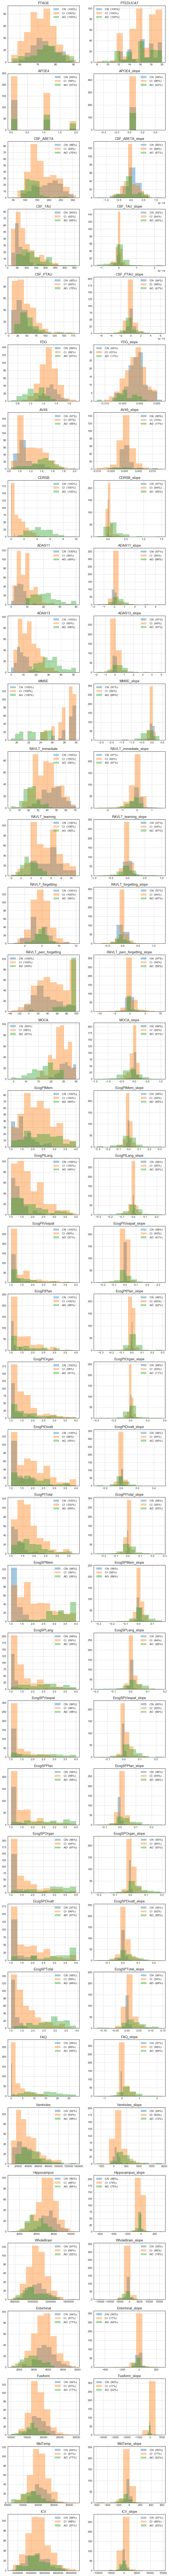

In [12]:
num_cont = 1 + len(cols_longit_bl)

adnimerge_unique_CN = adnimerge_unique[adnimerge_unique['DX_bl']==0]
adnimerge_unique_MC = adnimerge_unique[adnimerge_unique['DX_bl']==1]
adnimerge_unique_AD = adnimerge_unique[adnimerge_unique['DX_bl']==2]

fig, ax = plt.subplots(num_cont, 2, figsize=(12,200))

for i,col_name in enumerate(cols_demo_cont):
    mis_rate_CN = np.mean(adnimerge_unique_CN[col_name].isnull())
    mis_rate_MC = np.mean(adnimerge_unique_MC[col_name].isnull())
    mis_rate_AD = np.mean(adnimerge_unique_AD[col_name].isnull())
    adnimerge_unique_CN[col_name].hist(
        ax=ax[0,i], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CN', 100*(1-mis_rate_CN)))
    adnimerge_unique_MC[col_name].hist(
        ax=ax[0,i], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CI', 100*(1-mis_rate_MC)))
    adnimerge_unique_AD[col_name].hist(
        ax=ax[0,i], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('AD', 100*(1-mis_rate_AD)))
    ax[0,i].set_title(col_name)
    ax[0,i].legend(loc='best')

for i,col_name in enumerate(cols_longit_bl):
    mis_rate_CN = np.mean(adnimerge_unique_CN[col_name].isnull())
    mis_rate_MC = np.mean(adnimerge_unique_MC[col_name].isnull())
    mis_rate_AD = np.mean(adnimerge_unique_AD[col_name].isnull())
    adnimerge_unique_CN[col_name].hist(
        ax=ax[i+1,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CN', 100*(1-mis_rate_CN)))
    adnimerge_unique_MC[col_name].hist(
        ax=ax[i+1,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CI', 100*(1-mis_rate_MC)))
    adnimerge_unique_AD[col_name].hist(
        ax=ax[i+1,0], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('AD', 100*(1-mis_rate_AD)))
    ax[i+1,0].set_title(col_name)
    ax[i+1,0].legend(loc='best')
    
for i,col_name in enumerate(cols_longit_slope):
    mis_rate_CN = np.mean(adnimerge_unique_CN[col_name].isnull())
    mis_rate_MC = np.mean(adnimerge_unique_MC[col_name].isnull())
    mis_rate_AD = np.mean(adnimerge_unique_AD[col_name].isnull())
    adnimerge_unique_CN[col_name].hist(
        ax=ax[i+1,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CN', 100*(1-mis_rate_CN)))
    adnimerge_unique_MC[col_name].hist(
        ax=ax[i+1,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('CI', 100*(1-mis_rate_MC)))
    adnimerge_unique_AD[col_name].hist(
        ax=ax[i+1,1], alpha=0.4, 
        label='{:^4} ({:0.0f}%)'.format('AD', 100*(1-mis_rate_AD)))
    ax[i+1,1].set_title(col_name)
    ax[i+1,1].legend(loc='best')

## Correlation Heatmap

To avoid collinearity, we would like to examine the correlation between variables. We used heatmap to do so.

According to the heap map of all selected predictors, there are high correlations between the following
pairs of predictors: `CDRSB` vs `FAQ`, `ADAS11` vs `ADAS13`, `WholeBrain` vs `ICV`, and among all
`EcogXXX` predictors. To deal with these correlations, we deleted `ADAS11`, `EcogPtTotal` and `EcogSPTotal` based on the review of scientific papers that investigated the importance of the factors mentioned above related to the prediction of Alzheimer’s Disease. 

Note: The heatmap is obtained by only considering the value that are not None in both predictors.

In [13]:
def plot_correlation_heatmap(df1, df2, ax):
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    N1 = df1.shape[1]
    N2 = df2.shape[1]
    corr_matrix = np.zeros((N1, N2))
    for i,icol in enumerate(df1.columns):
        for j,jcol in enumerate(df2.columns):
            idx_available = np.where(
                (~df1[icol].isnull()) & (~df2[jcol].isnull()))
            ival = df1[icol].values[idx_available]
            jval = df2[jcol].values[idx_available]
            cov = np.mean(ival*jval) - np.mean(ival)*np.mean(jval)
            corr = cov / np.std(ival) / np.std(jval)
            corr_matrix[i,j] = corr
            
    ax.set_xticks(ticks=range(len(df2.columns)))
    ax.set_yticks(ticks=range(len(df1.columns)))
    ax.set_xticklabels(df2.columns, rotation='vertical')
    ax.set_yticklabels(df1.columns)
    plot = ax.pcolor(np.abs(corr_matrix), vmin=0, vmax=1)
    return plot

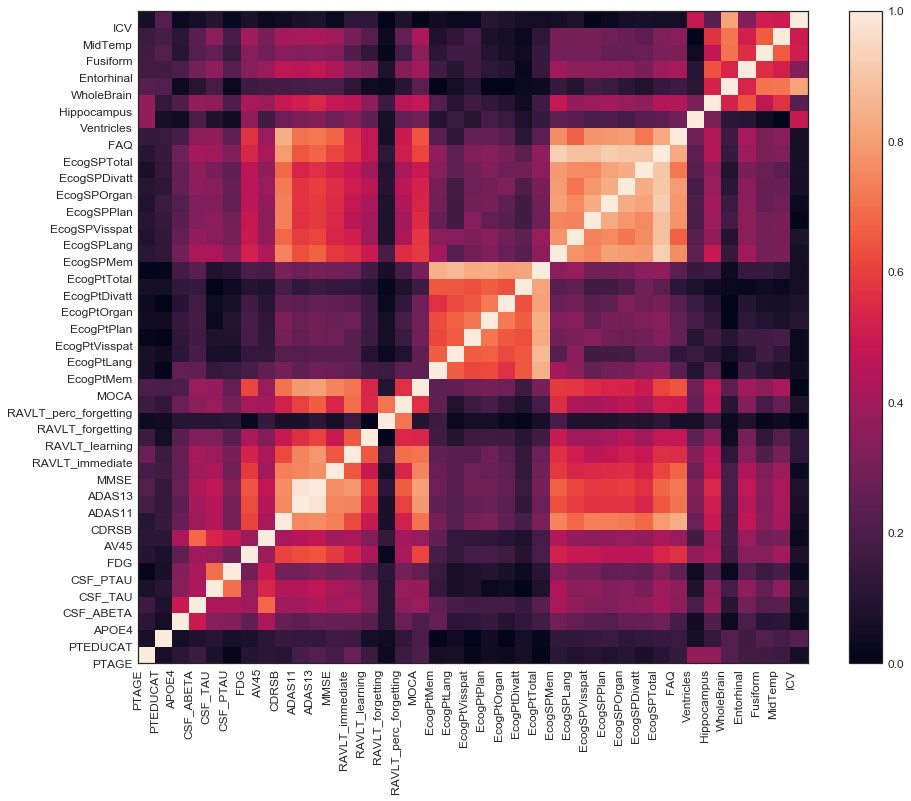

In [14]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_demo_cont+cols_longit_bl], 
    adnimerge_unique[cols_demo_cont+cols_longit_bl], ax)
fig.colorbar(plot)

We listed below the predictors that have a small slope in magnitude related to its value. We deleted these slope variables, `APOE4_slope`, `CSF_ABETA_slope`, `CSF_TAU_slope`, and `CSF_PTAU_slope` as they could not show any trend of the following visits of the patients and were meaningless. We also checked the collinearity of the slopes themselves. We ended up with the same conclusion as above. To deal with these correlations, we deleted `ADAS11_slope`, `EcogPtTotal_slope` and `EcogSPTotal_slope`. Further, we found that the slopes are not collinear with the predictors. 

In [15]:
tol_err = 1e-6
cols_longit_slope_valid = []
for cbl,csl in zip(cols_longit_bl,cols_longit_slope):
    bl = adnimerge_unique[cbl]
    sl = adnimerge_unique[csl]
    if np.std(sl) > tol_err*np.mean(bl):
        cols_longit_slope_valid.append(csl)
cols_longit_slope_invalid = [
    c for c in cols_longit_slope if c not in cols_longit_slope_valid]
print('Predictor slopes that are too small:\n', cols_longit_slope_invalid)

Predictor slopes that are too small:
 ['APOE4_slope', 'CSF_ABETA_slope', 'CSF_TAU_slope', 'CSF_PTAU_slope']


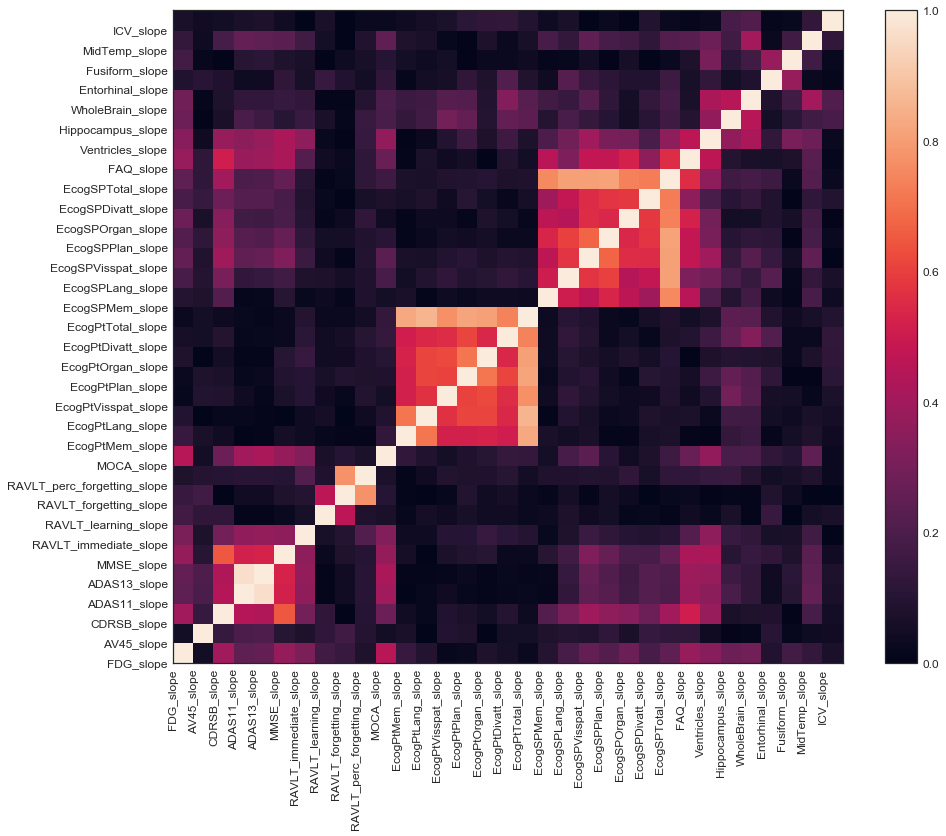

In [16]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_longit_slope_valid], 
    adnimerge_unique[cols_longit_slope_valid], ax)
fig.colorbar(plot)

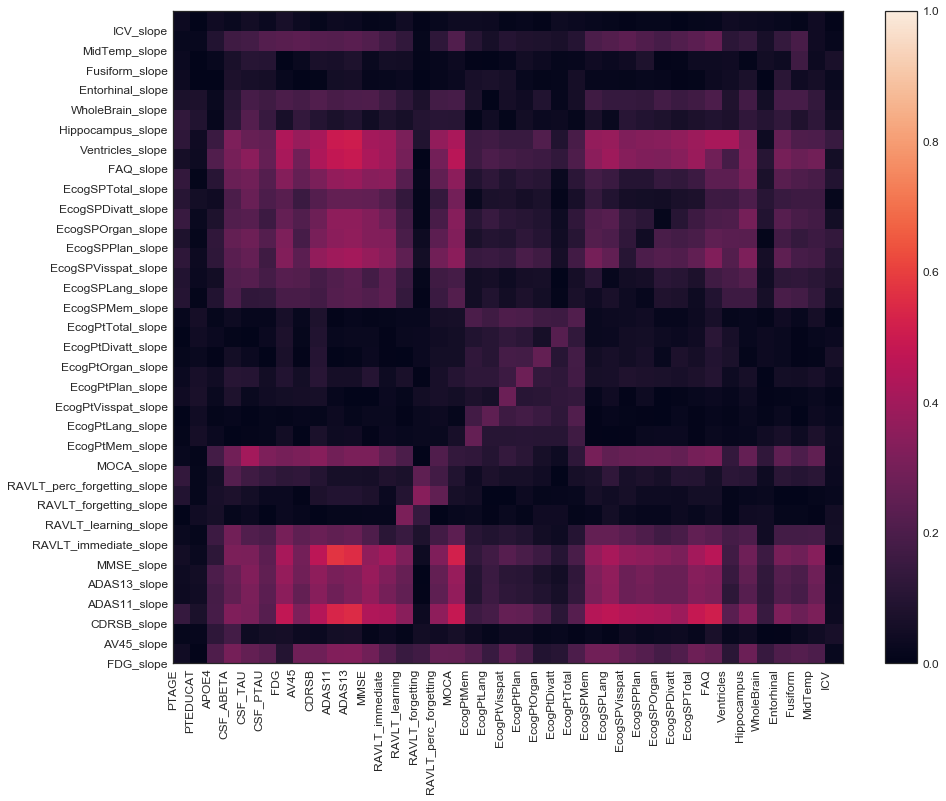

In [17]:
fig, ax = plt.subplots(figsize=(15,12))
plot = plot_correlation_heatmap(
    adnimerge_unique[cols_longit_slope[4:]],
    adnimerge_unique[cols_demo_cont+cols_longit_bl], ax)
fig.colorbar(plot)

## Drop Predictors

We dropped the predictors mentioned above.

In [18]:
del adnimerge_unique['CDRSB']
del adnimerge_unique['CDRSB_slope']

del adnimerge_unique['ADAS11']
del adnimerge_unique['EcogPtTotal']
del adnimerge_unique['EcogSPTotal']
del adnimerge_unique['ADAS11_slope']
del adnimerge_unique['EcogPtTotal_slope']
del adnimerge_unique['EcogSPTotal_slope']

del adnimerge_unique['APOE4_slope']
del adnimerge_unique['CSF_ABETA_slope']
del adnimerge_unique['CSF_TAU_slope']
del adnimerge_unique['CSF_PTAU_slope']

In [19]:
print(adnimerge_unique.shape)
adnimerge_unique.head()

(783, 77)


,RID,DX_bl,PTAGE,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
4001,4001,2,88.5,0,9,0,0,0,0,0,1,1,0,0,1,0.0,105.7,141.6,36.2,1.11537,0.000033,1.507200,NaN,38.0,0.234855,20.0,-0.186659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500,0.053791,1.11111,NaN,1.00000,NaN,1.0,NaN,1.00000,NaN,1.00,NaN,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,22.0,0.147061,33609.0,327.921234,5532.0,-13.555558,864483.0,-1766.049081,2995.0,-64.791139,14530.0,-3.466522,14249.0,-47.827089,1255450.0,-0.543778
4004,4004,1,66.8,0,14,0,0,0,0,0,1,1,0,0,0,0.0,208.1,83.3,33.9,1.26220,-0.003933,0.973711,-0.000457,5.0,0.051461,30.0,0.002234,53.0,-0.036797,5.0,0.033328,9.0,-0.070851,69.2308,-0.499578,27.0,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4005,4005,1,70.5,1,16,0,0,0,0,0,1,1,1,0,0,1.0,139.4,128.0,73.9,1.25009,0.000314,1.395770,0.001351,8.0,0.155971,29.0,0.045185,26.0,0.189440,1.0,-0.024890,6.0,0.011707,100.0000,0.023501,28.0,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,8.0,-0.061578,38294.0,268.520926,7207.0,-3.094318,1181170.0,-945.902809,4405.0,-1.281092,22968.0,-44.868160,22654.0,-40.787854,1768220.0,-346.827114
4007,4007,1,78.1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,144.3,86.2,40.5,1.33645,0.003553,1.653660,0.002966,14.0,-0.031164,29.0,0.046588,40.0,-0.174286,7.0,-0.159071,4.0,0.275438,36.3636,2.915744,24.0,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,1.0,-0.003882,36679.0,164.977666,7495.0,-25.103614,1029740.0,-865.813171,3522.0,0.192841,19848.0,-49.114981,19938.0,5.985021,1426170.0,-497.941640
4009,4009,2,90.3,1,17,0,0,0,0,0,1,0,1,0,0,0.0,233.9,71.4,22.1,1.17124,-0.001039,0.909650,-0.002026,25.0,0.171000,24.0,0.073440,25.0,-0.222341,1.0,-0.043417,3.0,0.033877,60.0000,1.355067,18.0,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75,-0.018569,3.625,0.009662,2.44444,0.017177,3.71429,0.013120,3.4,0.003900,3.00000,0.032227,2.75,0.043571,26.0,0.235116,29136.0,8.365721,5224.0,-28.069806,910905.0,-3162.821533,NaN,NaN,NaN,NaN,NaN,NaN,1338420.0,-1049.248536


## Imputation

The problem of missing values lies in the continuous variables. We imputed the missing values by mean. We did not impute by regression models because there were very few columns that had no missing data, and we could not build a satisfactory regression model based on that.

In [20]:
def imputation_mean(df, cols):
    df_copy = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        c_mean = np.mean(df[c])
        df_copy[c] = df[c].map(lambda x:c_mean if np.isnan(x) else x)
    return df_copy

In [21]:
cols_to_impute = cols_longit_bl + cols_longit_slope_valid
adnimerge_unique_imputed = imputation_mean(adnimerge_unique, cols_to_impute)
adnimerge_unique_imputed.head()

,RID,DX_bl,PTAGE,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
4001,4001,2,88.5,0,9,0,0,0,0,0,1,1,0,0,1,0.0,105.7,141.6,36.2,1.11537,0.000033,1.507200,0.000502,38.0,0.234855,20.0,-0.186659,37.18822,-0.103010,4.539052,-0.013343,4.368758,-0.010724,56.16988,0.180313,22.979301,-0.046780,1.500,0.053791,1.11111,-0.000064,1.00000,2.868415e-03,1.0,0.002403,1.00000,0.002204,1.00,0.002802,3.875,0.004211,1.00000,0.039147,2.25000,0.043828,3.6,0.013474,3.66667,0.011228,4.00,-0.010675,22.0,0.147061,33609.000000,327.921234,5532.00000,-13.555558,8.644830e+05,-1766.049081,2995.000000,-64.791139,14530.000000,-3.466522,14249.000000,-47.827089,1.255450e+06,-0.543778
4004,4004,1,66.8,0,14,0,0,0,0,0,1,1,0,0,0,0.0,208.1,83.3,33.9,1.26220,-0.003933,0.973711,-0.000457,5.0,0.051461,30.0,0.002234,53.00000,-0.036797,5.000000,0.033328,9.000000,-0.070851,69.23080,-0.499578,27.000000,0.047281,1.750,0.006296,1.66667,0.012584,1.85714,2.035398e-02,1.4,0.020378,1.50000,0.007639,2.00,0.009371,1.625,-0.005569,1.22222,0.000527,1.28571,-0.002936,1.8,-0.013355,1.33333,-0.005150,2.25,-0.016481,0.0,0.000000,37648.184722,221.307493,6992.62446,-13.605642,1.043388e+06,-824.231999,3576.089971,-8.352327,18087.830383,-32.266216,19935.085546,-32.674813,1.502300e+06,-124.516227
4005,4005,1,70.5,1,16,0,0,0,0,0,1,1,1,0,0,1.0,139.4,128.0,73.9,1.25009,0.000314,1.395770,0.001351,8.0,0.155971,29.0,0.045185,26.00000,0.189440,1.000000,-0.024890,6.000000,0.011707,100.00000,0.023501,28.000000,0.003579,2.125,0.007081,1.00000,0.010400,1.14286,8.180210e-03,1.4,0.004251,1.33333,-0.005677,1.50,0.003515,3.000,0.013977,2.33333,0.009818,2.57143,0.026097,2.2,0.032259,2.66667,0.018311,2.25,0.023470,8.0,-0.061578,38294.000000,268.520926,7207.00000,-3.094318,1.181170e+06,-945.902809,4405.000000,-1.281092,22968.000000,-44.868160,22654.000000,-40.787854,1.768220e+06,-346.827114
4007,4007,1,78.1,1,20,0,0,0,0,0,1,1,1,0,0,1.0,144.3,86.2,40.5,1.33645,0.003553,1.653660,0.002966,14.0,-0.031164,29.0,0.046588,40.00000,-0.174286,7.000000,-0.159071,4.000000,0.275438,36.36360,2.915744,24.000000,-0.054248,1.500,-0.010637,1.00000,0.000000,1.14286,2.273962e-17,1.0,0.000000,1.00000,0.000000,1.00,0.000000,2.625,-0.017011,1.55556,-0.026302,1.83333,-0.038269,2.6,-0.071456,1.83333,-0.038823,2.75,-0.036882,1.0,-0.003882,36679.000000,164.977666,7495.00000,-25.103614,1.029740e+06,-865.813171,3522.000000,0.192841,19848.000000,-49.114981,19938.000000,5.985021,1.426170e+06,-497.941640
4009,4009,2,90.3,1,17,0,0,0,0,0,1,0,1,0,0,0.0,233.9,71.4,22.1,1.17124,-0.001039,0.909650,-0.002026,25.0,0.171000,24.0,0.073440,25.00000,-0.222341,1.000000,-0.043417,3.000000,0.033877,60.00000,1.355067,18.000000,-0.013394,2.000,-0.009109,1.33333,-0.009468,2.14286,-3.698373e-02,1.8,-0.017324,2.00000,-0.027624,1.75,-0.018569,3.625,0.009662,2.44444,0.017177,3.71429,0.013120,3.4,0.003900,3.00000,0.032227,2.75,0.043571,26.0,0.235116,29136.000000,8.365721,5224.00000,-28.069806,9.109050e+05,-3162.821533,3576.089971,-8.352327,18087.830383,-32.266216,19935.085546,-32.674813,1.338420e+06

## Train Test Split

We used 80% of the data as training set and the remaining 20% as the test set.

In [22]:
# train test split
np.random.seed(9001)
msk = np.random.rand(adnimerge_unique_imputed.shape[0]) < 0.8
df_train = adnimerge_unique_imputed[msk]
df_test = adnimerge_unique_imputed[~msk]
print(df_train.shape)
print(df_test.shape)

(621, 77)
(162, 77)


In [16]:
# df_train.to_csv('data/ADNIMERGE_train.csv', index=False)
# df_test.to_csv('data/ADNIMERGE_test.csv', index=False)

## Load data

In [23]:
X_train = df_train.drop(['RID', 'DX_bl'], axis=1).copy()
y_train = df_train['DX_bl'].copy()
X_test = df_test.drop(['RID', 'DX_bl'], axis=1).copy()
y_test = df_test['DX_bl'].copy()

In [24]:
# function to help compare the accuracy of models
def score(model, X_train, y_train, X_test, y_test):
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    test_class0 = model.score(X_test[y_test==0], y_test[y_test==0])
    test_class1 = model.score(X_test[y_test==1], y_test[y_test==1])
    test_class2 = model.score(X_test[y_test==2], y_test[y_test==2])
    return pd.Series([train_acc, test_acc, test_class0, test_class1, test_class2],
                    index = ['Train accuracy', 'Test accuracy', 
                             "Test accuracy CN", "Test accuracy CI", "Test accuracy AD"])

## Baseline Model

We used `stratified` strategy as a simple baseline model to generate predictions to be compared with other classifiers we learned in class.

In [25]:
dc = DummyClassifier(strategy='stratified', random_state=9001)
dc.fit(X_train,y_train)
print('Dummy Classifier Training Score: ', dc.score(X_train,y_train))
print('Dummy Classifier Test Score: ', dc.score(X_test,y_test))
print('Dummy Classifier Confusion Matrix:\n', confusion_matrix(y_test,dc.predict(X_test)))
dc_score = score(dc, X_train, y_train, X_test, y_test)

Dummy Classifier Training Score:  0.423510466989
Dummy Classifier Test Score:  0.444444444444
Dummy Classifier Confusion Matrix:
 [[14 19  9]
 [27 52 14]
 [ 7 14  6]]


## Logistic Regression

We tested 6 kinds of logistic regression, logistic regression with l1 penalty, logistic regression with l2 penalty, unweighted logistic regression, weighted logistic regression, one-vs-rest logistic regression and multinomial logistic regression. We chose the best parameters with cross validation. We found that a large regularization term is needed for all classifiers, indicating that we have too many variables.

In [26]:
#l1
log_l1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', random_state=9001)
log_l1.fit(X_train,y_train)

#l2
log_l2 = LogisticRegressionCV(penalty = 'l2', random_state=9001)
log_l2.fit(X_train,y_train)

#Unweighted logistic regression
unweighted_logistic = LogisticRegressionCV(random_state=9001)
unweighted_logistic.fit(X_train,y_train)

#Weighted logistic regression
weighted_logistic = LogisticRegressionCV(class_weight='balanced', random_state=9001)
weighted_logistic.fit(X_train,y_train)

#ovr
log_ovr = LogisticRegressionCV(multi_class = 'ovr', random_state=9001)
log_ovr.fit(X_train,y_train)

#multinomial
log_multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg', random_state=9001)
log_multinomial.fit(X_train,y_train)

print("Regularization strength: ")
print("-------------------------")
print("Logistic regression with l1 penalty:", log_l1.C_[0])
print("Logistic regression with l2 penalty:", log_l2.C_[0])
print("Unweighted logistic regression: ", unweighted_logistic.C_[0])
print("Weighted logistic regression: ", weighted_logistic.C_[0])
print("OVR logistic regression: ", log_ovr.C_[0])
print("Multinomial logistic regression: ", log_multinomial.C_[0])

Regularization strength: 
-------------------------
Logistic regression with l1 penalty: 0.35938136638
Logistic regression with l2 penalty: 0.00599484250319
Unweighted logistic regression:  0.00599484250319
Weighted logistic regression:  0.0464158883361
OVR logistic regression:  0.00599484250319
Multinomial logistic regression:  2.78255940221


In [27]:
#Computing the score on the train set - 
print("Training accuracy")
print("-------------------------------------------------")
print('Logistic Regression with l1 penalty train Score: ',log_l1.score(X_train, y_train))
print('Logistic Regression with l2 penalty train Score: ',log_l2.score(X_train, y_train))
print('Unweighted Logistic Regression with train Score: ',unweighted_logistic.score(X_train, y_train))
print('Weighted Logistic Regression train Score: ',weighted_logistic.score(X_train, y_train))
print('OVR Logistic Regression train Score: ',log_ovr.score(X_train, y_train))
print('Multinomial Logistic Regression train Score: ',log_multinomial.score(X_train, y_train))

print('\n')

#Computing the score on the test set - 
print("Test accuracy")
print("-------------------------------------------------")
print('Logistic Regression with l1 penalty test Score: ',log_l1.score(X_test, y_test))
print('Logistic Regression with l2 penalty test Score: ',log_l2.score(X_test, y_test))
print('Unweighted Logistic Regression test Score: ',unweighted_logistic.score(X_test, y_test))
print('Weighted Logistic Regression test Score: ',weighted_logistic.score(X_test, y_test))
print('OVR Logistic Regression test Score: ',log_ovr.score(X_test, y_test))
print('Multinomial Logistic Regression test Score: ',log_multinomial.score(X_test, y_test))

Training accuracy
-------------------------------------------------
Logistic Regression with l1 penalty train Score:  0.830917874396
Logistic Regression with l2 penalty train Score:  0.621578099839
Unweighted Logistic Regression with train Score:  0.621578099839
Weighted Logistic Regression train Score:  0.471819645733
OVR Logistic Regression train Score:  0.621578099839
Multinomial Logistic Regression train Score:  0.845410628019


Test accuracy
-------------------------------------------------
Logistic Regression with l1 penalty test Score:  0.827160493827
Logistic Regression with l2 penalty test Score:  0.592592592593
Unweighted Logistic Regression test Score:  0.592592592593
Weighted Logistic Regression test Score:  0.401234567901
OVR Logistic Regression test Score:  0.592592592593
Multinomial Logistic Regression test Score:  0.808641975309


In [28]:
# store the accuracy score
l1_score = score(log_l1, X_train, y_train, X_test, y_test)
l2_score = score(log_l2, X_train, y_train, X_test, y_test)
weighted_score = score(weighted_logistic, X_train, y_train, X_test, y_test)
unweighted_score = score(unweighted_logistic, X_train, y_train, X_test, y_test)
ovr_score = score(log_ovr, X_train, y_train, X_test, y_test)
multi_score = score(log_multinomial, X_train, y_train, X_test, y_test)

In [29]:
# confusion matrix
l1_pred = log_l1.predict(X_test)
l2_pred = log_l2.predict(X_test)
weighted_pred = weighted_logistic.predict(X_test)
unweighted_pred = unweighted_logistic.predict(X_test)
ovr_pred = log_ovr.predict(X_test)
multi_pred = log_multinomial.predict(X_test)

print("Confusion Matrix")
print("Logistic Regression with l1 penalty:\n",
      confusion_matrix(y_test, l1_pred))
print("Logistic Regression with l2 penalty:\n",
      confusion_matrix(y_test, l2_pred))
print("Unweighted Logistic Regression:\n",
      confusion_matrix(y_test, unweighted_pred))
print("Weighted Logistic Regression:\n",
      confusion_matrix(y_test, weighted_pred))
print("OVR Logistic Regression:\n",
      confusion_matrix(y_test, ovr_pred))
print("Multinomial Logistic Regression:\n",
      confusion_matrix(y_test, multi_pred))

Confusion Matrix
Logistic Regression with l1 penalty:
 [[27 15  0]
 [ 5 84  4]
 [ 0  4 23]]
Logistic Regression with l2 penalty:
 [[ 0 42  0]
 [ 0 86  7]
 [ 0 17 10]]
Unweighted Logistic Regression:
 [[ 0 42  0]
 [ 0 86  7]
 [ 0 17 10]]
Weighted Logistic Regression:
 [[30  7  5]
 [48 18 27]
 [ 3  7 17]]
OVR Logistic Regression:
 [[ 0 42  0]
 [ 0 86  7]
 [ 0 17 10]]
Multinomial Logistic Regression:
 [[28 14  0]
 [ 9 79  5]
 [ 0  3 24]]


## Discriminant Analysis

We performed normalization on continuous predictors and used Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) as our models. LDA performs really well.

In [30]:
# normalization
cols_standardize = [
    c for c in X_train.columns 
    if (not c.startswith('PT')) \
        or (c=='PTEDUCAT') or (c=='PTAGE')]

X_train_std = X_train.copy()
X_test_std = X_test.copy()
for c in cols_standardize:
    col_mean = np.mean(X_train[c])
    col_sd = np.std(X_train[c])
    if col_sd > (1e-10)*col_mean:
        X_train_std[c] = (X_train[c]-col_mean)/col_sd
        X_test_std[c] = (X_test[c]-col_mean)/col_sd

In [31]:
X_train_std.head()

,PTAGE,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
4001,2.208480,0,-2.852257,0,0,0,0,0,1,1,0,0,1,-0.823084,-1.421715,1.137347,-0.321586,-0.833130,0.811782,1.257634,0.023763,2.140034,0.236256,-2.742373,-0.471665,-0.010026,-0.001926,0.003844,-0.000699,0.028414,-0.018332,0.019484,-0.012471,-0.003150,-0.004052,-0.827740,1.136728,-0.981277,-0.002156,-0.715234,-0.030329,-0.713577,-0.002410,-0.843488,-0.007633,-1.076964,-0.016544,1.929076,-0.088208,-0.844339,0.954666,1.066767,1.048123,2.524016,0.060641,2.287022,0.021430,2.330806,-0.631242,2.934694,0.124173,-0.205919,0.381384,-1.351616,0.022285,-1.761500,-0.567555,-0.820814,-1.269796,-1.426968,0.156847,-2.102069,-0.192827,-1.574482,0.093937
4007,0.759714,1,1.376909,0,0,0,0,0,1,1,1,0,0,0.703236,-0.567568,-0.086517,-0.128000,0.602793,2.864460,1.903103,1.199280,-0.210782,-0.364551,0.586715,0.595629,0.202187,-0.189405,0.884055,-0.907178,-0.118596,1.750365,-0.556812,1.770545,0.227228,-0.044392,-0.827740,-0.229483,-1.153377,-0.000458,-0.444998,-0.101471,-0.713577,-0.065235,-0.843488,-0.064451,-1.076964,-0.072474,0.573694,-0.738447,-0.106940,-1.151805,0.487637,-1.687565,1.262926,-2.477232,0.148179,-1.526413,0.971872,-1.384981,-0.484392,-0.424658,-0.053348,-0.251084,0.483644,-0.306894,-0.134464,-0.028641,-0.070387,0.188014,0.721399,-0.067438,0.019784,0.506511,-0.489132,-0.265646
4010,-0.257208,0,0.607970,0,0,0,0,0,1,1,1,0,0,-0.823084,-0.775573,-1.038657,-0.920353,0.572072,0.019993,0.547072,0.023763,-0.798486,-0.710060,0.586715,0.463914,1.183334,1.011032,0.884055,-0.590705,0.280068,-1.497230,-0.495770,-1.722958,0.452935,0.701979,-0.530055,-0.049247,-0.464974,-0.085273,-0.715234,-0.033968,-0.713577,-0.065235,-0.018265,0.055382,-0.053520,0.069781,-1.052764,0.042214,-0.844339,-0.077852,-0.670610,-0.211993,-0.754818,0.111691,-0.824015,-0.212459,-0.930635,0.246899,-0.647205,-0.415515,-0.294977,-0.883418,-1.104796,0.020857,-1.300396,0.310720,0.456478,-0.560840,0.292776,0.016824,-0.650452,0.224140,-1.239633,-0.014198
4012,-0.521887,0,-0.160970,0,0,0,0,0,1,1,0,0,0,-0.823084,-0.445863,0.222762,0.322200,0.441716,0.850276,-0.548541,-0.049974,-0.994388,-0.282924,0.586715,0.519651,0.730497,0.190865,-0.546632,0.454839,-0.915923,1.164759,-1.032937,0.965802,0.678642,0.204009,0.387783,0.167724,0.223444,0.375527,-0.174781,0.049689,-0.007973,0.191936,0.531879,0.404523,1.652218,0.250482,-0.103997,-0.010217,-0.844339,-0.186429,-0.670610,-0.271617,-0.754818,-0.343706,-0.824015,-0.076909,-0.115275,0.065754,-0.484392,-0.473929,-0.005181,-0.032439,0.013960,0.020857,-0.000094,-0.003749,0.006635,-0.003683,0.010325,0.015345,0.018697,0.004091,-0.005136,0.004314
4014,1.121905,1,-0.160970,0,0,0,0,0,1,1,0,0,1,-0.823084,-1.521292,0.516578,0.056582,0.613315,1.113319,1.781157,0.338415,-0.602585,-0.189067,0.586715,0.476561,-0.099704,0.488832,-0.546632,0.189374,-0.118596,0.780831,-0.160039,0.662249,-0.449892,0.202553,-0.133156,0.119957,-0.809176,0.038450,-0.444998,-0.146690,-0.360775,-0.127391,0.806959,-0.571339,0.287627,-0.263162,0.709232,0.108071,-0.401908,0.

In [32]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train_std,y_train)
qda.fit(X_train_std,y_train)

# training accuracy
print("Training accuracy")
print("------------------")
print('LDA Train Score: ',lda.score(X_train_std,y_train))
print('QDA Train Score: ',qda.score(X_train_std,y_train))

print('\n')

# test accuracy
print("Test accuracy")
print("------------------")
print('LDA Test Score: ',lda.score(X_test_std,y_test))
print('QDA Test Score: ',qda.score(X_test_std,y_test))

Training accuracy
------------------
LDA Train Score:  0.848631239936
QDA Train Score:  0.822866344605


Test accuracy
------------------
LDA Test Score:  0.814814814815
QDA Test Score:  0.66049382716


In [33]:
# store the accuracy score
lda_score = score(lda, X_train_std, y_train, X_test_std, y_test)
qda_score = score(qda, X_train_std, y_train, X_test_std, y_test)

In [34]:
# confusion matrix
lda_pred = lda.predict(X_test_std)
qda_pred = qda.predict(X_test_std)

print("Confusion Matrix")
print("LDA:\n",
      confusion_matrix(y_test, lda_pred))
print("QDA:\n",
      confusion_matrix(y_test, qda_pred))

Confusion Matrix
LDA:
 [[30 12  0]
 [10 78  5]
 [ 1  2 24]]
QDA:
 [[23 18  1]
 [10 64 19]
 [ 0  7 20]]


## K-Nearest Neighbours

The optimal number of neighbours is 41, which is a relatively large number considering that we only have 783 observations. The accuracy is not satisfactory as well.

In [35]:
cv_fold = KFold(n_splits=5, shuffle=True, random_state=9001)

max_score = 0
max_k = 0 

for k in range(1,60):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_val_score = cross_val_score(knn, X_train, y_train, cv=cv_fold).mean()
    if knn_val_score > max_score:
        max_k = k
        max_score = knn_val_score
        
knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(X_train,y_train)

print("Optimal number of neighbours: ", max_k)
print('KNN Training Accuracy: ', knn.score(X_train,y_train))
print('KNN Test Accuracy: ', knn.score(X_test,y_test))

# Store the accuracy score
knn_score = score(knn, X_train, y_train, X_test, y_test)

Optimal number of neighbours:  41
KNN Training Accuracy:  0.566827697262
KNN Test Accuracy:  0.574074074074


In [36]:
# confusion matrix
knn_pred = knn.predict(X_test)

print("KNN Confusion Matrix:\n",
      confusion_matrix(y_test, knn_pred))

KNN Confusion Matrix:
 [[ 0 42  0]
 [ 0 92  1]
 [ 1 25  1]]


## Decision Tree

We used 5-fold cross validation to find the optimal depth for the decision tree. The optimal depth is 6.

In [37]:
depth = []
for i in range(3,20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=9001)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=cv_fold, n_jobs=-1)
    depth.append((i, scores.mean(), scores.std())) 
depthvals = [t[0] for t in depth]
cvmeans = np.array([t[1] for t in depth])
cvstds = np.array([t[2] for t in depth])
max_indx = np.argmax(cvmeans)
md_best = depthvals[max_indx]
print('Optimal depth:',md_best)
dt_best = DecisionTreeClassifier(max_depth=md_best, random_state=9001)
dt_best.fit(X_train, y_train).score(X_test, y_test)
dt_score = score(dt_best, X_train, y_train, X_test, y_test)

Optimal depth: 6


In [38]:
print('Decision Tree Training Accuracy: ', dt_best.score(X_train,y_train))
print('Decision Tree Test Accuracy: ', dt_best.score(X_test,y_test))

Decision Tree Training Accuracy:  0.90499194847
Decision Tree Test Accuracy:  0.746913580247


In [39]:
# confusion matrix
dt_pred = dt_best.predict(X_test)

print("Decision Tree Confusion Matrix:\n",
      confusion_matrix(y_test, dt_pred))

Decision Tree Confusion Matrix:
 [[24 18  0]
 [19 73  1]
 [ 0  3 24]]


## Random Forest

We used `GridSearchCV` to find the optimal number of trees and tree depth. We then used the optimal value to perform random forest classification.

In [40]:
trees = [2**x for x in range(8)]  # 1, 2, 4, 8, 16, 32, ...
depth = [2, 4, 6, 8, 10, 12, 14, 16]
parameters = {'n_estimators': trees,
              'max_depth': depth}
rf = RandomForestClassifier(random_state=9001)
rf_cv = GridSearchCV(rf, parameters, cv=cv_fold)
rf_cv.fit(X_train, y_train)
best_score = np.argmax(rf_cv.cv_results_['mean_test_score'])
result = rf_cv.cv_results_['params'][best_score]
opt_depth = result['max_depth']
opt_tree = result['n_estimators']
print("Optimal number of trees {}, tree depth: {}".format(opt_tree, opt_depth))
rf = RandomForestClassifier(n_estimators=opt_tree, max_depth=opt_depth, random_state=9001)
rf.fit(X_train, y_train)
print('\n')
print('Random Forest Training Accuracy: ', rf.score(X_train,y_train))
print('Random Forest Test Accuracy: ', rf.score(X_test,y_test))
rf_score = score(rf, X_train, y_train, X_test, y_test)

Optimal number of trees 32, tree depth: 12


Random Forest Training Accuracy:  0.998389694042
Random Forest Test Accuracy:  0.802469135802


In [41]:
# confusion matrix
rf_pred = rf.predict(X_test)

print("Random Forest Confusion Matrix:\n",
      confusion_matrix(y_test, rf_pred))

Random Forest Confusion Matrix:
 [[20 22  0]
 [ 5 85  3]
 [ 0  2 25]]


## AdaBoost

We used the optimal tree depth found by cross validation in the decision tree classifier, and performed `GridSearchCV` to find the optimal number of trees and learning rate.

In [42]:
trees = [2**x for x in range(6)]  # 1, 2, 4, 8, 16, 32, ...
learning_rate = [0.1, 0.5, 1, 5]
parameters = {'n_estimators': trees,
              'learning_rate': learning_rate}
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=md_best),
                        random_state=9001)
ab_cv = GridSearchCV(ab, parameters, cv=cv_fold)
ab_cv.fit(X_train, y_train)
best_score = np.argmax(ab_cv.cv_results_['mean_test_score'])
result = ab_cv.cv_results_['params'][best_score]
opt_learning_rate = result['learning_rate']
opt_tree = result['n_estimators']
print("Optimal number of trees {}, learning rate: {}".format(opt_tree, opt_learning_rate))
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=md_best), n_estimators=opt_tree,
                       learning_rate=opt_learning_rate, random_state=9001)
ab.fit(X_train, y_train)
print('\n')
print('AdaBoost Training Accuracy: ', ab.score(X_train,y_train))
print('AdaBoost Test Accuracy: ', ab.score(X_test,y_test))
ab_score = score(ab, X_train, y_train, X_test, y_test)

Optimal number of trees 16, learning rate: 1


AdaBoost Training Accuracy:  1.0
AdaBoost Test Accuracy:  0.740740740741


In [43]:
# confusion matrix
ab_pred = ab.predict(X_test)

print("AdaBoost Confusion Matrix:\n",
      confusion_matrix(y_test, ab_pred))

AdaBoost Confusion Matrix:
 [[20 22  0]
 [13 76  4]
 [ 0  3 24]]



## Performance Summary

In [44]:
score_df = pd.DataFrame({'Dummy Classifier': dc_score,
                         'Logistic Regression with l1': l1_score, 
                         'Logistic Regression with l2': l2_score,
                         'Weighted logistic': weighted_score,
                         'Unweighted logistic': unweighted_score,
                         'OVR': ovr_score,
                         'Multinomial': multi_score,
                         'KNN': knn_score,
                         'LDA': lda_score,
                         'QDA': qda_score,
                         'Decision Tree': dt_score,
                         'Random Forest': rf_score,
                         'AdaBoost': ab_score})
score_df

,AdaBoost,Decision Tree,Dummy Classifier,KNN,LDA,Logistic Regression with l1,Logistic Regression with l2,Multinomial,OVR,QDA,Random Forest,Unweighted logistic,Weighted logistic
Train accuracy,1.000000,0.904992,0.423510,0.566828,0.848631,0.830918,0.621578,0.845411,0.621578,0.822866,0.998390,0.621578,0.471820
Test accuracy,0.740741,0.746914,0.444444,0.574074,0.814815,0.827160,0.592593,0.808642,0.592593,0.660494,0.802469,0.592593,0.401235
Test accuracy CN,0.476190,0.571429,0.333333,0.000000,0.714286,0.642857,0.000000,0.666667,0.000000,0.547619,0.476190,0.000000,0.714286
Test accuracy CI,0.817204,0.784946,0.516129,0.989247,0.838710,0.903226,0.924731,0.849462,0.924731,0.688172,0.913978,0.924731,0.193548
Test accuracy AD,0.888889,0.888889,0.222222,0.037037,0.888889,0.851852,0.370370,0.888889,0.370370,0.740741,0.925926,0.370370,0.629630


To better visualize the accuracies of each classification models, we first ordered the models by their test accuracies and compared both training and test accuracies in the bar plot.

In [45]:
names_sorted = [
    pair[0] for pair in sorted(
        zip(score_df.columns, score_df.loc['Test accuracy']), 
        key=lambda x:x[1], reverse=False) ]
names_ticks = [
    n.replace(' ','\n') for n in names_sorted ]

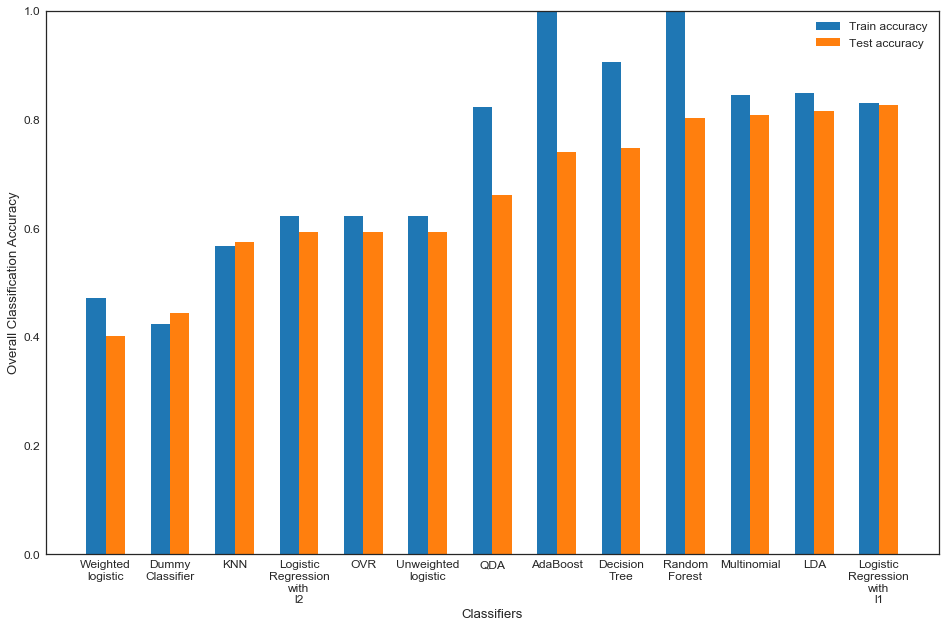

In [46]:
bar_width = 0.3
plt.figure(figsize = (16,10))
for i,idx in enumerate(score_df.index[:2]):
    plt.bar(np.arange(len(names_sorted))+i*bar_width, score_df[names_sorted].loc[idx], 
            bar_width, color=sns.color_palette()[i], label=idx)
plt.xticks(np.arange(len(names_sorted))+0.15, names_ticks)
plt.ylabel('Overall Classification Accuracy')
plt.xlabel('Classifiers')
plt.legend(loc='best')
plt.ylim(0,1)
plt.show()

The we compare their test accuracies on three classes `CN`, `CI` and `AD` respectively.

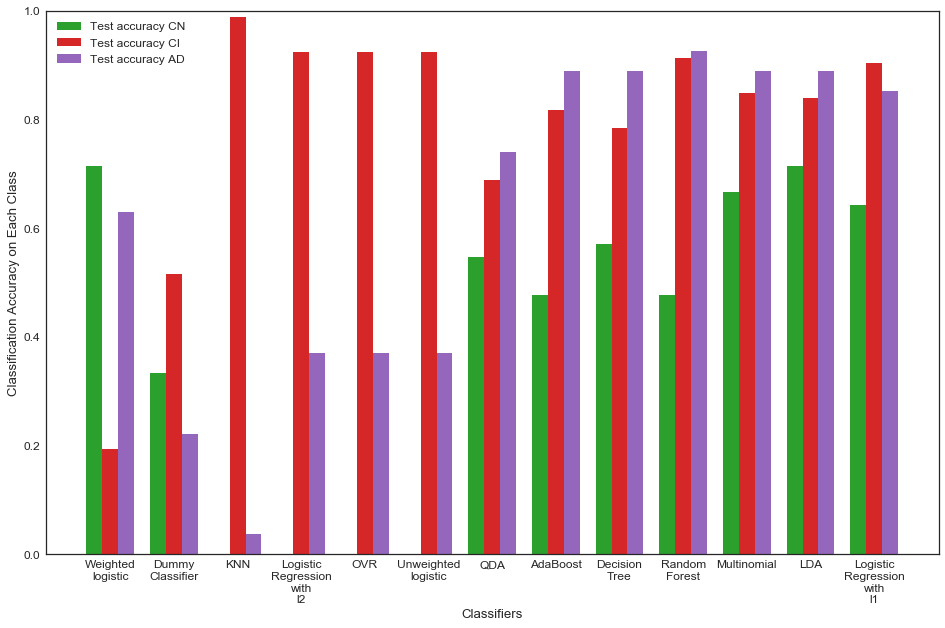

In [47]:
bar_width = 0.3
plt.figure(figsize = (16,10))
for i,idx in enumerate(score_df.index[2:]):
    plt.bar(1.2*np.arange(len(names_sorted))+i*bar_width, score_df[names_sorted].loc[idx], 
            bar_width, color=sns.color_palette()[i+2], label=idx)
plt.xticks(1.2*np.arange(len(names_sorted))+0.3, names_ticks)
plt.ylabel('Classification Accuracy on Each Class')
plt.xlabel('Classifiers')
plt.legend(loc='best')
plt.ylim(0,1)
plt.show()

For baseline models, people usually use the dummy classifier with the "stratified" strategy or the "most frequent" strategy. The "stratified" method generates prediction according to the class distribution of the training set. The "most frequent" strategy always predicts the most frequent class. We adopted the `stratified` strategy implemented by `sklearn`'s `DummyClassifer` as a baseline model. As can be seen above, almost all other classification models we used outperformed the dummy classifier as expected.

Based on the above summary, `AdaBoost` and `Random Forest` have almost perfect training accuracy. Three classifiers with the highest test accuracies are `Random Forest` (0.802469), `LDA` (0.814815) and `Logistic Regression with l1` (0.827160), among which `Logistic Regression with l1` has the best performance.

For classifying `CN` patients, weighted logistic regression has the highest test accuracy (0.785714), so it performs the best for determining Cognitively Normal patients. However, KNN, logistic regression with l2 regularization, OvR logistic regression and unweighted logistic regression have zero accuracy on classifying `CN` patients. Since all of them have very high accuracy on `CI` but low accuracy on `AD`, we think these four models probably classify almost all the `CN` patients into `CI` (as can been seen in the confusion matrices), leading to zero accuracy on `CN` and high accuracy on `CI`.

KNN has the highest test accuracy (0.989247) on diagnosing `CI` cognitive impairment patients. Logistic regression with l1 regularization, logistic regression with l2 regularization, random forest classifier, OvR logistic regression and unweighted logistic regression all reach 0.9 accuracy on diagnosing `CI` patients.

Since we focus on the diagnosis of Alzheimer's disease, we are more concerned about the test accuracy on `AD` patients. Random forest classifier has the highest test accuracy (0.925926) on `AD` patients. Adaboost, LDA, decision tree, logistic regression with l1 regularization and multinomial logistic regression all achieve test accuracy of over 0.85 on the classification of `AD`.

In addition, we find an interesting pattern in the above barplots of accuracy. There seems to be three types of classifiers. Type I includes `Weighted Logistic` and `Dummy Classifier`. Their overall accuracies are at a relatively low level around 0.40. Type II includes `KNN`, `Logistic Regression with l2`, `OvR` and `Unweighted Logistic`. Their overall accuracies are at a midium level around 0.60, and their partial accuracies on the three classes are very unbalanced. None of them can predict correctly on `CN`. Type III includes `QDA`, `AdaBoost`, `Decision Tree`, `Multinomial`, `Random Forest`, `LDA` and `Logistic Regression with l1`. Their overall accuracies are at a relatively high level over 0.70, and their partial accuracies on the three classes are basically balanced. Every Type III classifier has its own advantage and can be competitive substitution to each other.

To conclude, `Logistic Regression with l1`, `LDA` and `Random Forest` perform the best if we are concerned about both overall test accuracy and correctly diagnosing `AD` patients. Other models such as `QDA`, `AdaBoost`, `Decision Tree` and `Multinomial` are also promising.

# Significance of Predictors

We would like to find out the most significant variables in the model. These variables have the strongest predicting power, and are thus the most useful in the diagnosis of Alzheimer's disease. Identifying these variables can eliminate the number of tests a patient has to go through to get an accurate diagnosis. 

For logistic regression with l1 regularization, we used bootstraping (200 iterations) to find the most significant predictors. For random forest, we chcked the returned attribute `feature_importances_`.

## Bootstrapping

In [4]:
log_l1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear',random_state=9001)
log_l1.fit(X_train,y_train)
c = log_l1.C_[0]

iterations = 200
boot = np.zeros((X_train.shape[1], iterations))
for i in range(iterations):
    np.random.seed(2*i)
    boot_rows = np.random.choice(range(X_train.shape[0]),
                                 size=X_train.shape[0], replace=True)
    X_train_boot = X_train.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]
    model_boot = LogisticRegression(penalty = 'l1', C=c)
    model_boot.fit(X_train_boot, y_train_boot)
    boot[:,i] = model_boot.coef_[2,:]
    
boot_ci_upper = np.percentile(boot, 95, axis=1)
boot_ci_lower = np.percentile(boot, 5, axis=1)
sig_b_ct = []
for i in range(X_train.shape[1]):
    if boot_ci_upper[i]<0 or boot_ci_lower[i]>0:
        sig_b_ct.append(i)
        
print("Most significant coefficients: ",len(sig_b_ct))
print(X_train.columns[sig_b_ct])

Most significant coefficients:  5
Index(['ADAS13', 'MMSE', 'RAVLT_immediate', 'FAQ', 'ICV_slope'], dtype='object')


Surprisingly, we only have 5 significant predictors using bootstrapping and four of them are cognitive assessments which don't cost as much as brain imaing tests. Specifically, the significant assessments are: 
- **`ADAS13`**: Alzheimer’s Disease Assessment Scale
- **`MMSE`**: Mini-Mental State Examination
- **`RAVLT_immediate`**: Rey Auditory Verbal Learning Immediate Test
- **`FAQ`**: Functional Activities Questionnaire in Older Adults with Dementia
We found this result a bit doubtful because no brain imaging tests are picked as significant predictors while studies have shown the important role of brain imaging in diagnosing Alzheimer's Disease. However, if other models also give similar results, patients are likely to save a lot of money and time. 
- **`ICV_slope`**: The change of intracranial vault volume in magnetic resonance imaging (MRI) result

## Feature importance by Random Forest

In [5]:
rf_best = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
rf_best.fit(X_train, y_train)
imp_features = np.array(X_train.columns)[rf_best.feature_importances_!=0]
print("The most important {} features:".format(len(imp_features)))
print(imp_features)

The most important 73 features:
['PTAGE' 'PTGENDER' 'PTEDUCAT' 'PTRACCAT_Asian' 'PTRACCAT_Black'
 'PTRACCAT_More_than_one' 'PTRACCAT_White' 'PTETHCAT_Not_Hisp/Latino'
 'PTMARRY_Married' 'PTMARRY_Never_married' 'PTMARRY_Widowed' 'APOE4'
 'CSF_ABETA' 'CSF_TAU' 'CSF_PTAU' 'FDG' 'FDG_slope' 'AV45' 'AV45_slope'
 'ADAS13' 'ADAS13_slope' 'MMSE' 'MMSE_slope' 'RAVLT_immediate'
 'RAVLT_immediate_slope' 'RAVLT_learning' 'RAVLT_learning_slope'
 'RAVLT_forgetting' 'RAVLT_forgetting_slope' 'RAVLT_perc_forgetting'
 'RAVLT_perc_forgetting_slope' 'MOCA' 'MOCA_slope' 'EcogPtMem'
 'EcogPtMem_slope' 'EcogPtLang' 'EcogPtLang_slope' 'EcogPtVisspat'
 'EcogPtVisspat_slope' 'EcogPtPlan' 'EcogPtPlan_slope' 'EcogPtOrgan'
 'EcogPtOrgan_slope' 'EcogPtDivatt' 'EcogPtDivatt_slope' 'EcogSPMem'
 'EcogSPMem_slope' 'EcogSPLang' 'EcogSPLang_slope' 'EcogSPVisspat'
 'EcogSPVisspat_slope' 'EcogSPPlan' 'EcogSPPlan_slope' 'EcogSPOrgan'
 'EcogSPOrgan_slope' 'EcogSPDivatt' 'EcogSPDivatt_slope' 'FAQ' 'FAQ_slope'
 'Ventricles' 'V

In [20]:
list(set(X_train.columns) - set(imp_features))

['PTRACCAT_Unknown', 'PTRACCAT_Hawaiian/Other_PI']

### Significance ranking of predictors

In [6]:
imp = rf_best.feature_importances_
ranks_rf = np.searchsorted(np.sort(imp), imp)
ranks_rf=len(ranks_rf)-ranks_rf
ranks_rf

array([14, 65, 61, 67, 71, 75, 69, 75, 68, 73, 64, 72, 70, 66, 28, 11, 58,
       16, 23, 15, 52,  3, 30,  1, 10, 12, 41, 56, 38, 62, 47,  8, 48,  7,
       22,  4, 46,  6, 45, 59, 44, 63, 57, 60, 54, 43, 37,  2, 27, 19, 18,
       51, 25, 26, 32, 20, 49,  9, 39,  5, 13, 31, 21, 24, 42, 29, 36, 17,
       50, 34, 35, 55, 40, 33, 53])

In [7]:
ranked_x_rf = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_rf):
    ranked_x_rf[rank-1] = X_train.columns[i]
print('Ranked Predictors by Random Forest Feature Importance:\n')
print(ranked_x_rf)

Ranked Predictors by Random Forest Feature Importance:

['MMSE', 'EcogSPMem', 'ADAS13', 'EcogPtMem', 'FAQ', 'EcogPtLang', 'MOCA', 'RAVLT_perc_forgetting', 'EcogSPDivatt', 'MMSE_slope', 'CSF_TAU', 'RAVLT_immediate', 'FAQ_slope', 'PTAGE', 'AV45', 'FDG', 'Entorhinal', 'EcogSPLang_slope', 'EcogSPLang', 'EcogSPOrgan', 'Ventricles_slope', 'MOCA_slope', 'FDG_slope', 'Hippocampus', 'EcogSPVisspat_slope', 'EcogSPPlan', 'EcogSPMem_slope', 'CSF_ABETA', 'WholeBrain', 'ADAS13_slope', 'Ventricles', 'EcogSPPlan_slope', 'ICV', 'Fusiform', 'Fusiform_slope', 'WholeBrain_slope', 'EcogPtDivatt_slope', 'RAVLT_learning_slope', 'EcogSPDivatt_slope', 'MidTemp_slope', 'RAVLT_immediate_slope', 'Hippocampus_slope', 'EcogPtDivatt', 'EcogPtVisspat_slope', 'EcogPtLang_slope', 'EcogPtMem_slope', 'RAVLT_forgetting_slope', 'RAVLT_perc_forgetting_slope', 'EcogSPOrgan_slope', 'Entorhinal_slope', 'EcogSPVisspat', 'AV45_slope', 'ICV_slope', 'EcogPtOrgan_slope', 'MidTemp', 'RAVLT_learning', 'EcogPtPlan_slope', 'CSF_PTAU', 

Using random forest classifier, we ended up with 73 important features. Only `PTRACCAT_Hawaiian/Other_PI` and `PTRACCAT_Unknown` are not significant, both of which are indicators of race. 

Notably, among the top 15 ranked predictors, `MMSE`, `FAQ`, `ADAS13`, and `RAVLT_immediate` appear again (also appeared in bootstrapping result), which add even more significance to these cognitive tests. Additionally, many `Every Cognition Test` (ECogxxx) results are also shown to be significant here. We will see how they perfrom in the following selections.

## Forward and Backward Selections

In [8]:
def step_forwards_backwards(direction='forward'):
    
    assert direction in ['forward', 'backward']

    predictors = set(X_train.columns)
    predictors_ls = list(X_train.columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = X_train.shape[0]
    best_acc = np.inf
    
    best_accuracy = []
    best_models = []
    
    rank = 0
    
    if direction == 'forward':
        ranks = [len(predictors_ls)-1]*len(predictors_ls)
        X = X_train[list(selected_predictors)].values
        while (True):
            
            possible_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)
            for predictor in possible_predictors:
                x_temp = np.concatenate([X, X_train[predictor].values.reshape(-1,1)], axis=1)
                rf = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
                scores = np.mean(cross_val_score(rf, x_temp, y_train, cv=cv_fold))
                possible_scores.append(scores)
                
            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            ranks[predictors_ls.index(best_predictor)]=rank
            
            best_acc = np.max(possible_scores)
            best_accuracy.append(best_acc)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, X_train[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))
            
            rank += 1

    else:
        ranks = [0]*len(predictors_ls)
        while (True):
            possible_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break
            cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)              
            for predictor in possible_predictors:
    
                X = np.concatenate([np.ones(n).reshape(-1,1), 
                                    X_train[list(selected_predictors - set([predictor]))].values], 
                                   axis=1)
                if(X.shape[1] != 0):
                    rf = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
                    scores = np.mean(cross_val_score(rf, X, y_train, cv=cv_fold))
                    possible_scores.append(scores)

            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix] 
            ranks[predictors_ls.index(best_predictor)]=len(predictors_ls)-rank-1

            best_acc = possible_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_accuracy.append(best_acc)
            best_models.append(list(selected_predictors))
            
            rank += 1
            
    index_of_best_accuracy = np.argmax(best_accuracy)

    return (best_models[index_of_best_accuracy],ranks)

In [9]:
predictors_forward,ranks_f = step_forwards_backwards(direction='forward')
predictors_backward,ranks_b = step_forwards_backwards(direction='backward')

### Significance ranking of predictors by stepwise selections

We calculated the significance rankings of predictors to compare the rankings produced by different selection methods.

In [10]:
print("Predictors selected by forward selection (", 
      len(predictors_forward), " predictors): \n", predictors_forward,'\n',ranks_f)
print("\n-----------------------------------------\n")
print("Predictors selected by backward selection: (", 
      len(predictors_backward), " predictors): \n", predictors_backward,'\n',ranks_b)

Predictors selected by forward selection ( 15  predictors): 
 ['PTAGE', 'AV45_slope', 'PTMARRY_Never_married', 'WholeBrain_slope', 'ADAS13', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'PTRACCAT_Unknown', 'FAQ', 'EcogPtMem', 'FDG_slope', 'MMSE', 'CSF_TAU', 'PTRACCAT_Hawaiian/Other_PI', 'EcogSPMem'] 
 [6, 67, 71, 34, 56, 7, 24, 8, 19, 10, 25, 14, 63, 61, 69, 3, 49, 29, 13, 72, 11, 0, 53, 5, 58, 48, 21, 46, 44, 16, 66, 54, 64, 40, 41, 4, 35, 45, 27, 62, 31, 60, 17, 32, 52, 59, 38, 2, 20, 36, 43, 55, 22, 23, 47, 42, 33, 74, 39, 12, 26, 51, 28, 70, 65, 50, 1, 73, 15, 57, 9, 37, 68, 30, 18]

-----------------------------------------

Predictors selected by backward selection: ( 13  predictors): 
 ['PTAGE', 'MMSE', 'PTMARRY_Married', 'ICV_slope', 'EcogPtLang', 'PTGENDER', 'EcogSPLang_slope', 'MidTemp_slope', 'FDG_slope', 'ICV', 'EcogSPPlan', 'PTRACCAT_Hawaiian/Other_PI', 'RAVLT_perc_forgetting_slope'] 
 [9, 7, 43, 39, 63, 11, 68, 70, 22, 65, 6, 71, 64, 19, 30, 13, 53, 32, 3, 36, 47, 72, 62

In [11]:
ranked_x_forward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_f):
    ranked_x_forward[rank] = X_train.columns[i]
print('Ranked Predictors by Forward Selection:\n')
print(ranked_x_forward)

Ranked Predictors by Forward Selection:

['ADAS13', 'WholeBrain_slope', 'EcogSPMem', 'CSF_TAU', 'EcogPtMem', 'MMSE', 'PTAGE', 'PTRACCAT_Hawaiian/Other_PI', 'PTRACCAT_Unknown', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'AV45_slope', 'FAQ', 'FDG_slope', 'PTMARRY_Never_married', 'Entorhinal_slope', 'RAVLT_forgetting', 'EcogPtPlan_slope', 'ICV_slope', 'PTRACCAT_White', 'EcogSPMem_slope', 'RAVLT_immediate_slope', 'EcogSPVisspat_slope', 'EcogSPPlan', 'PTRACCAT_More_than_one', 'PTMARRY_Married', 'FAQ_slope', 'EcogPtLang_slope', 'Ventricles_slope', 'FDG', 'ICV', 'EcogPtVisspat_slope', 'EcogPtOrgan', 'EcogSPOrgan_slope', 'PTRACCAT_Asian', 'EcogPtMem_slope', 'EcogSPLang', 'MidTemp', 'EcogPtDivatt_slope', 'EcogSPDivatt_slope', 'MOCA', 'MOCA_slope', 'EcogSPOrgan', 'EcogSPLang_slope', 'RAVLT_learning_slope', 'EcogPtLang', 'RAVLT_learning', 'EcogSPPlan_slope', 'RAVLT_immediate', 'CSF_PTAU', 'WholeBrain', 'Ventricles', 'EcogPtOrgan_slope', 'ADAS13_slope', 'RAVLT_perc_forgetting', 'EcogSPVisspat',

In [12]:
ranked_x_backward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_b):
    ranked_x_backward[rank] = X_train.columns[i]
print('Ranked Predictors by Backward Selection:\n')
print(ranked_x_backward)

Ranked Predictors by Backward Selection:

['MMSE', 'EcogSPPlan', 'EcogPtLang', 'FDG_slope', 'MidTemp_slope', 'RAVLT_perc_forgetting_slope', 'PTMARRY_Married', 'PTGENDER', 'EcogSPLang_slope', 'PTAGE', 'ICV_slope', 'PTRACCAT_Hawaiian/Other_PI', 'ICV', 'CSF_TAU', 'EcogPtVisspat_slope', 'EcogSPDivatt_slope', 'Entorhinal_slope', 'EcogSPDivatt', 'Fusiform', 'APOE4', 'EcogSPMem_slope', 'EcogPtDivatt', 'PTRACCAT_White', 'Fusiform_slope', 'MMSE_slope', 'RAVLT_perc_forgetting', 'EcogPtOrgan_slope', 'MOCA', 'EcogPtMem_slope', 'RAVLT_learning', 'CSF_ABETA', 'EcogPtVisspat', 'FDG', 'Hippocampus', 'RAVLT_learning_slope', 'EcogPtOrgan', 'AV45', 'RAVLT_immediate_slope', 'WholeBrain_slope', 'PTRACCAT_Asian', 'WholeBrain', 'EcogPtLang_slope', 'Ventricles', 'PTEDUCAT', 'EcogSPLang', 'FAQ_slope', 'MOCA_slope', 'AV45_slope', 'EcogSPOrgan_slope', 'EcogPtPlan_slope', 'RAVLT_forgetting', 'EcogSPPlan_slope', 'RAVLT_forgetting_slope', 'CSF_PTAU', 'RAVLT_immediate', 'EcogPtDivatt_slope', 'MidTemp', 'EcogPtMem', 

### Combined significant predictors selected by random forest classifier, forward and backward selections

We combined all significant predictors selected by random forest classifier, forward and backward selections. There are 24 predictors in total. We will further explain the pattern of these predictors in the last part of this section.

In [22]:
forward = set(predictors_forward)
backward = set(predictors_backward)
inter_f_b = forward.union(backward)
print('Combined significant predictors by forward and backward selection:\n')
print(inter_f_b)

Combined significant predictors by forward and backward selection:

{'PTAGE', 'PTMARRY_Married', 'EcogPtLang', 'PTMARRY_Never_married', 'MidTemp_slope', 'EcogSPPlan', 'WholeBrain_slope', 'ADAS13', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'ICV_slope', 'FAQ', 'EcogPtMem', 'FDG_slope', 'MMSE', 'PTRACCAT_Unknown', 'PTRACCAT_Hawaiian/Other_PI', 'AV45_slope', 'PTGENDER', 'EcogSPLang_slope', 'ICV', 'CSF_TAU', 'RAVLT_perc_forgetting_slope', 'EcogSPMem'}


## Rank-Rank plot 

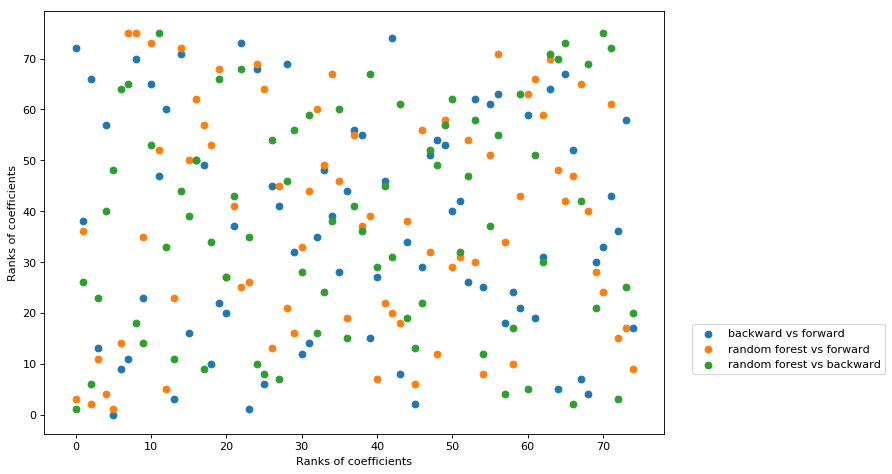

In [14]:
from sklearn.linear_model import LinearRegression

fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(ranks_f,ranks_b,label='backward vs forward')
plt.scatter(ranks_f,ranks_rf,label='random forest vs forward')
plt.scatter(ranks_b,ranks_rf,label='random forest vs backward')

plt.legend(loc='center', bbox_to_anchor=(1.2, 0.2), ncol=1)
plt.xlabel('Ranks of coefficients')
plt.ylabel('Ranks of coefficients')
plt.show()

There seems to be no pattern when we compare the importance of predictors ranked by different methods.

## Model Testing on the Selected Variables

In [15]:
X_train_best1 = X_train[list(inter_f_b)]
X_test_best1 = X_test[list(inter_f_b)]
X_train_best2 = X_train[list(X_train.columns[sig_b_ct])]
X_test_best2 = X_test[list(X_train.columns[sig_b_ct])]
cv_fold = KFold(n_splits=5, shuffle=True, random_state=9001)

### Logistic Regression Model 
with common predictors from RF, Forward, and Backward selection

In [17]:
model_ = LogisticRegression(penalty = 'l1', C=c)
model_.fit(X_train_best2, y_train)
model_.score(X_test_best2,y_test)
score(model_, X_train_best2, y_train, X_test_best2, y_test)

Train accuracy      0.710145
Test accuracy       0.691358
Test accuracy CN    0.023810
Test accuracy CI    0.935484
Test accuracy AD    0.888889
dtype: float64

### Random Forest Classifier
with common predictors from RF, Forward, and Backward selection

In [18]:
trees = [2**x for x in range(8)]  # 1, 2, 4, 8, 16, 32, ...
depth = [2, 4, 6, 8, 10]
parameters = {'n_estimators': trees,
              'max_depth': depth}
rf = RandomForestClassifier(random_state=9001)
rf_cv = GridSearchCV(rf, parameters, cv=cv_fold)
rf_cv.fit(X_train_best1, y_train)
best_score = np.argmax(rf_cv.cv_results_['mean_test_score'])
result = rf_cv.cv_results_['params'][best_score]
opt_depth = result['max_depth']
opt_tree = result['n_estimators']
print("Optimal number of trees {}, tree depth: {}".format(opt_tree, opt_depth))
rf = RandomForestClassifier(n_estimators=opt_tree, max_depth=opt_depth, random_state=9001)
rf.fit(X_train_best1, y_train)
print('\n')
print('Random Forest Training Accuracy: ', rf.score(X_train_best1,y_train))
print('Random Forest Test Accuracy: ', rf.score(X_test_best1,y_test))
rf_score = score(rf, X_train_best1, y_train, X_test_best1, y_test)
rf_score

Optimal number of trees 32, tree depth: 10


Random Forest Training Accuracy:  0.995169082126
Random Forest Test Accuracy:  0.753086419753


Train accuracy      0.995169
Test accuracy       0.753086
Test accuracy CN    0.476190
Test accuracy CI    0.860215
Test accuracy AD    0.814815
dtype: float64

Since the test result of variables selected from only bootstrapping does not perform as well as that of the combined significant variables, we choose to rely on the significant predictors selected by the union of the forward and backward selections. Let's interpret the selected predictors:

- The tests completely excluded are: `FDG`, and `MOCA`, indicating the results of those tests are not significant in the diagnosis, possibly because other assessments are testing similar aspects of the patients.

- The factors that are significant themselves but insignificant in their slopes are: `MMSE`, `EcogSPMem`, `ADAS13`, `EcogPtMem`, `CSF_TAU`, `FAQ`, `EcogPtLang`, and `EcogSPPlan`, so tests associated with these factors only need to be done once at the baseline visit and are not necessary in the following visits. Specifically, Mini-Mental State Examination(`MMSE`), Everyday Cognition test on Participant Memory and Language, Study Partner Memory and Plan(`EcogSPMem`, `EcogPtMem`,`EcogPtLang`,`EcogSPPlan`), Functional Activities Questionnaire in Older Adults with Dementia(`FAQ`), Alzheimer’s Disease Assessment Scale(`ADAS13`) and biosample test(`CSF_TAU`) only need to be checked at the first visit.

- The factors that are significant in their slopes are: `AV45_slope`, `EcogSPLang_slope`, `WholeBrain_slope`, `MidTemp_slope`, `Fusiform_slope`, `FDG_slope`, `RAVLT_perc_forgetting_slope` and `ICV_slope`, which mean that the change in these parameters within two years after the first visit is quite important for the diagnosis. So checking these parameters on each subsequent visit is necessary. Specifically, The tests that need to be conducted in every visit are **Ecog** (Everyday Cognition)test on study partner language, **AV45** test, **FDG** imaging test, **RAVLT_learning** test and **MRI** test.

- Other significant demographic factors are: `PTAGE`(age), `PTMARRY_Married`, `PTMARRY_Never_married` (marital status), `PTETHCAT_Not_Hisp/Latino`, `PTRACCAT_Unknown`, and `PTRACCAT_Hawaiian/Other_PI` (ethnicity and race). 


Remarkably, `MMSE` appears in the results of all variable selection methods shown above. So we can conclude that it's an essetial test in the diagnosis of AD.

## Neural Networks

To obtain higher classification accuracy, we implemented neural networks, which we did not learn in the class. Multi-layer perceptrons neural network is a supervised method, and is very powerful in classifying Alzheimer's disease as shown below.

In [48]:
cols_standardize = [
    c for c in X_train.columns 
    if (not c.startswith('PT')) \
        or (c=='PTEDUCAT') or (c=='PTAGE')]

X_train_std = X_train.copy()
X_test_std = X_test.copy()
for c in cols_standardize:
    col_mean = np.mean(X_train[c])
    col_sd = np.std(X_train[c])
    if col_sd > (1e-10)*col_mean:
        X_train_std[c] = (X_train[c]-col_mean)/col_sd
        X_test_std[c] = (X_test[c]-col_mean)/col_sd

In [49]:
print(X_train_std.shape)
X_train_std.head()

(621, 75)


,PTAGE,PTGENDER,PTEDUCAT,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other_PI,PTRACCAT_More_than_one,PTRACCAT_Unknown,PTRACCAT_White,PTETHCAT_Not_Hisp/Latino,PTMARRY_Married,PTMARRY_Never_married,PTMARRY_Widowed,APOE4,CSF_ABETA,CSF_TAU,CSF_PTAU,FDG,FDG_slope,AV45,AV45_slope,ADAS13,ADAS13_slope,MMSE,MMSE_slope,RAVLT_immediate,RAVLT_immediate_slope,RAVLT_learning,RAVLT_learning_slope,RAVLT_forgetting,RAVLT_forgetting_slope,RAVLT_perc_forgetting,RAVLT_perc_forgetting_slope,MOCA,MOCA_slope,EcogPtMem,EcogPtMem_slope,EcogPtLang,EcogPtLang_slope,EcogPtVisspat,EcogPtVisspat_slope,EcogPtPlan,EcogPtPlan_slope,EcogPtOrgan,EcogPtOrgan_slope,EcogPtDivatt,EcogPtDivatt_slope,EcogSPMem,EcogSPMem_slope,EcogSPLang,EcogSPLang_slope,EcogSPVisspat,EcogSPVisspat_slope,EcogSPPlan,EcogSPPlan_slope,EcogSPOrgan,EcogSPOrgan_slope,EcogSPDivatt,EcogSPDivatt_slope,FAQ,FAQ_slope,Ventricles,Ventricles_slope,Hippocampus,Hippocampus_slope,WholeBrain,WholeBrain_slope,Entorhinal,Entorhinal_slope,Fusiform,Fusiform_slope,MidTemp,MidTemp_slope,ICV,ICV_slope
4001,2.208480,0,-2.852257,0,0,0,0,0,1,1,0,0,1,-0.823084,-1.421715,1.137347,-0.321586,-0.833130,0.811782,1.257634,0.023763,2.140034,0.236256,-2.742373,-0.471665,-0.010026,-0.001926,0.003844,-0.000699,0.028414,-0.018332,0.019484,-0.012471,-0.003150,-0.004052,-0.827740,1.136728,-0.981277,-0.002156,-0.715234,-0.030329,-0.713577,-0.002410,-0.843488,-0.007633,-1.076964,-0.016544,1.929076,-0.088208,-0.844339,0.954666,1.066767,1.048123,2.524016,0.060641,2.287022,0.021430,2.330806,-0.631242,2.934694,0.124173,-0.205919,0.381384,-1.351616,0.022285,-1.761500,-0.567555,-0.820814,-1.269796,-1.426968,0.156847,-2.102069,-0.192827,-1.574482,0.093937
4007,0.759714,1,1.376909,0,0,0,0,0,1,1,1,0,0,0.703236,-0.567568,-0.086517,-0.128000,0.602793,2.864460,1.903103,1.199280,-0.210782,-0.364551,0.586715,0.595629,0.202187,-0.189405,0.884055,-0.907178,-0.118596,1.750365,-0.556812,1.770545,0.227228,-0.044392,-0.827740,-0.229483,-1.153377,-0.000458,-0.444998,-0.101471,-0.713577,-0.065235,-0.843488,-0.064451,-1.076964,-0.072474,0.573694,-0.738447,-0.106940,-1.151805,0.487637,-1.687565,1.262926,-2.477232,0.148179,-1.526413,0.971872,-1.384981,-0.484392,-0.424658,-0.053348,-0.251084,0.483644,-0.306894,-0.134464,-0.028641,-0.070387,0.188014,0.721399,-0.067438,0.019784,0.506511,-0.489132,-0.265646
4010,-0.257208,0,0.607970,0,0,0,0,0,1,1,1,0,0,-0.823084,-0.775573,-1.038657,-0.920353,0.572072,0.019993,0.547072,0.023763,-0.798486,-0.710060,0.586715,0.463914,1.183334,1.011032,0.884055,-0.590705,0.280068,-1.497230,-0.495770,-1.722958,0.452935,0.701979,-0.530055,-0.049247,-0.464974,-0.085273,-0.715234,-0.033968,-0.713577,-0.065235,-0.018265,0.055382,-0.053520,0.069781,-1.052764,0.042214,-0.844339,-0.077852,-0.670610,-0.211993,-0.754818,0.111691,-0.824015,-0.212459,-0.930635,0.246899,-0.647205,-0.415515,-0.294977,-0.883418,-1.104796,0.020857,-1.300396,0.310720,0.456478,-0.560840,0.292776,0.016824,-0.650452,0.224140,-1.239633,-0.014198
4012,-0.521887,0,-0.160970,0,0,0,0,0,1,1,0,0,0,-0.823084,-0.445863,0.222762,0.322200,0.441716,0.850276,-0.548541,-0.049974,-0.994388,-0.282924,0.586715,0.519651,0.730497,0.190865,-0.546632,0.454839,-0.915923,1.164759,-1.032937,0.965802,0.678642,0.204009,0.387783,0.167724,0.223444,0.375527,-0.174781,0.049689,-0.007973,0.191936,0.531879,0.404523,1.652218,0.250482,-0.103997,-0.010217,-0.844339,-0.186429,-0.670610,-0.271617,-0.754818,-0.343706,-0.824015,-0.076909,-0.115275,0.065754,-0.484392,-0.473929,-0.005181,-0.032439,0.013960,0.020857,-0.000094,-0.003749,0.006635,-0.003683,0.010325,0.015345,0.018697,0.004091,-0.005136,0.004314
4014,1.121905,1,-0.160970,0,0,0,0,0,1,1,0,0,1,-0.823084,-1.521292,0.516578,0.056582,0.613315,1.113319,1.781157,0.338415,-0.602585,-0.189067,0.586715,0.476561,-0.099704,0.488832,-0.546632,0.189374,-0.118596,0.780831,-0.160039,0.662249,-0.449892,0.202553,-0.133156,0.119957,-0.809176,0.038450,-0.444998,-0.146690,-0.360775,-0.127391,0.806959,-0.571339,0.287627,-0.263162,0.709232,0.108071,-0.401908,0.

In [50]:
# find the best parameters
cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 0.3, 1, 3, 1e1, 1e2, 1e3],
              'hidden_layer_sizes': [(50), (100), (200), (500), 
                                     (50, 10), (50, 25), 
                                     (100, 10)]}
mlp = MLPClassifier(solver='lbfgs', activation='logistic', random_state=9001)
mlp_cv = GridSearchCV(mlp, parameters, cv=cv_fold)
mlp_cv.fit(X_train_std, y_train)
best_score = np.argmax(mlp_cv.cv_results_['mean_test_score'])
result = mlp_cv.cv_results_['params'][best_score]
a = result['alpha']
hidden_layer = result['hidden_layer_sizes']
mlp = MLPClassifier(solver='lbfgs', activation='logistic', random_state=9001,
                    alpha = a, hidden_layer_sizes=hidden_layer)
mlp = mlp.fit(X_train_std, y_train)

In [51]:
print("Optimal parameters")
print("L2 penalty parameter: ", a)
print("Hidden Layer Sizes: ", hidden_layer)
print('\n-----------------\n')
print("Training accuracy: ", mlp.score(X_train_std, y_train))
print("Test accuracy: ", mlp.score(X_test_std, y_test))
print('\n-----------------\n')
print('Test Confusion Matrix: ')
print(confusion_matrix(y_test, mlp.predict(X_test_std)))
nn_score = score(mlp, X_train_std, y_train, X_test_std, y_test)

Optimal parameters
L2 penalty parameter:  3
Hidden Layer Sizes:  50

-----------------

Training accuracy:  0.917874396135
Test accuracy:  0.802469135802

-----------------

Test Confusion Matrix: 
[[27 15  0]
 [ 9 81  3]
 [ 0  5 22]]


In [52]:
# random forest to compare with
rf_best = RandomForestClassifier(n_estimators=32, max_depth=12, random_state=9001)
rf_best.fit(X_train, y_train)
rf_score = score(rf_best, X_train, y_train, X_test, y_test)
print('\n-----------------\n')
print("Training accuracy: ", rf_best.score(X_train, y_train))
print("Test accuracy: ", rf_best.score(X_test, y_test))
print('\n-----------------\n')
print('Test Confusion Matrix: ')
print(confusion_matrix(y_test, rf_best.predict(X_test)))


-----------------

Training accuracy:  0.998389694042
Test accuracy:  0.802469135802

-----------------

Test Confusion Matrix: 
[[20 22  0]
 [ 5 85  3]
 [ 0  2 25]]


In [53]:
score_df = pd.DataFrame({"Neural Network": nn_score,
                         "Random Forest": rf_score})
score_df

,Neural Network,Random Forest
Train accuracy,0.917874,0.998390
Test accuracy,0.802469,0.802469
Test accuracy CN,0.642857,0.476190
Test accuracy CI,0.870968,0.913978
Test accuracy AD,0.814815,0.925926


The optimal hidden layer size is 1 hidden layer with 200 neurons. We need a l2-regularization term with value 3 to achieve the best accuracy.

The overall test accuracy of neural networks is better than that of random forest classifier. It also has a significantly higher accuracy on `CN` cognitively normal people, while its accuracies on `CI` cognitive impairment and `AD` Alzheimer's disease are slightly lower. We would say that the neural networks model belongs to the group of Type III classifiers discussed in the previous section. It is also a very promising model.